In [3]:
#Imports 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

#two choices for lightgbm
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier


In [8]:
#datas
df=pd.read_csv('cleaned_data.csv')
df

,MIS_Status,LoanNr_ChkDgt,State,Zip,UrbanRural,Bank,BankState,NAICS,NoEmp,NewExist,...,FranchiseCode,IsFranchise,Term,RevLineCr,LowDoc,DisbursementGross,ApprovalDate,ApprovalFY,GrAppv,SBA_Appv
0,1,1000014003,IN,47711,0,FIFTH THIRD BANK,OH,451120,4,2.0,...,1,1,84,0,1,60000.0,1997-02-28,1997,60000.0,48000.0
1,1,1000024006,IN,46526,0,1ST SOURCE BANK,IN,722410,2,2.0,...,1,1,60,0,1,40000.0,1997-02-28,1997,40000.0,32000.0
2,1,1000034009,IN,47401,0,GRANT COUNTY STATE BANK,IN,621210,7,1.0,...,1,1,180,0,0,287000.0,1997-02-28,1997,287000.0,215250.0
3,1,1000044001,OK,74012,0,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,...,1,1,60,0,1,35000.0,1997-02-28,1997,35000.0,28000.0
4,1,1000054004,FL,32801,0,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,...,1,1,240,0,0,229000.0,1997-02-28,1997,229000.0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,1,9995573004,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,6,1.0,...,1,1,60,0,0,70000.0,1997-02-27,1997,70000.0,56000.0
899160,1,9995603000,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,6,1.0,...,1,1,60,0,0,85000.0,1997-02-27,1997,85000.0,42500.0
899161,1,9995613003,CA,93455,0,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,26,1.0,...,1,1,108,0,0,300000.0,1997-02-27,1997,300000.0,225000.0
899162,0,9995973006,HI,96830,0,BANK OF HAWAII,HI,0,6,1.0,...,1,1,60,0,1,75000.0,1997-02-27,1997,75000.0,60000.0


### First test based on interactive doc

In [25]:
#Encoding categorical values with LabelEncoder
label_encoders = {}
categorical_cols = ['Zip', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'MIS_Status']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  #Conversion in str type to avoid mistakes
    label_encoders[col] = le  # Stock the encoder if needed after for the prediction

#Selection of valuable features
features = ['Zip', 'NAICS', 'ApprovalFY', 'NewExist', 'CreateJob', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc']


X = df[features] 
y = df['MIS_Status'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Logistic regression 
model = LogisticRegression(max_iter=100, solver='lbfgs')
model.fit(X_train, y_train)

#Predictions and values
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

#Result
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8245
Confusion Matrix:
[[     0  31564]
 [     1 148268]]


# Test avec LightGBM

#### Test avec HistGradientBoostingClassifier (from sklearn)

In [29]:
df.columns

Index(['MIS_Status', 'LoanNr_ChkDgt', 'State', 'Zip', 'UrbanRural', 'Bank',
       'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'IsFranchise', 'Term', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'ApprovalDate', 'ApprovalFY', 'GrAppv',
       'SBA_Appv'],
      dtype='object')

In [85]:
#Test with HistGradientBoostRegressor
features = ['State','Zip','UrbanRural','Bank','BankState','NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'IsFranchise', 'Term', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'ApprovalDate', 'ApprovalFY', 'GrAppv']

X = df[features]
y = df['MIS_Status']

label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']

for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X['ApprovalDate']=pd.to_datetime(X['ApprovalDate'])
X['ApprovalDate']=X["ApprovalDate"].dt.year


cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 
            'IsFranchise', 'RevLineCr', 'LowDoc']

for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = HistGradientBoostingClassifier(max_bins=255, max_iter=100, categorical_features="from_dtype")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')


/tmp/ipykernel_70556/2860251282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/2860251282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/2860251282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

Accuracy: 0.948


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
# Assuming y_true are the actual labels and y_pred are the predicted labels
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)  # Convert probabilities to class labels (for binary classification)

# Metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')  # 'weighted' for multi-class
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.9479
Precision: 0.9469
Recall: 0.9479
F1 Score: 0.9471
ROC AUC Score: 0.8958733842725979


In [73]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/2726703298.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


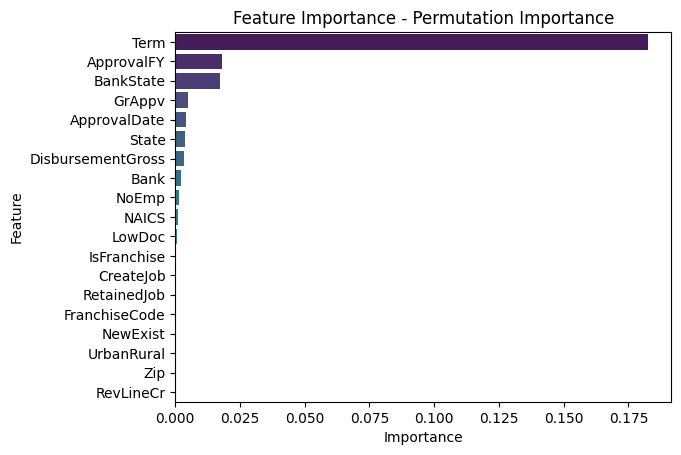

In [87]:
# Calcul de l'importance des features par permutation
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Extraire les importances moyennes
importances = result.importances_mean

# Créer un DataFrame pour affichage
features_names = X_test.columns
importance_df = pd.DataFrame({"Feature": features_names, "Importance": importances})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot avec Seaborn
#plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Importance")
plt.show()

### Test avec LGBM Classifier

In [88]:
#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Label encoding
label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']
for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=100, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_70556/3267484716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/3267484716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/3267484716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc, categorical_column=0,2,4,7,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
Accuracy: 0.9491
Precision: 0.9481
Recall: 0.9491
F1 Score: 0.9484
ROC AUC Score: 0.8989256495416058


In [89]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/2487718227.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


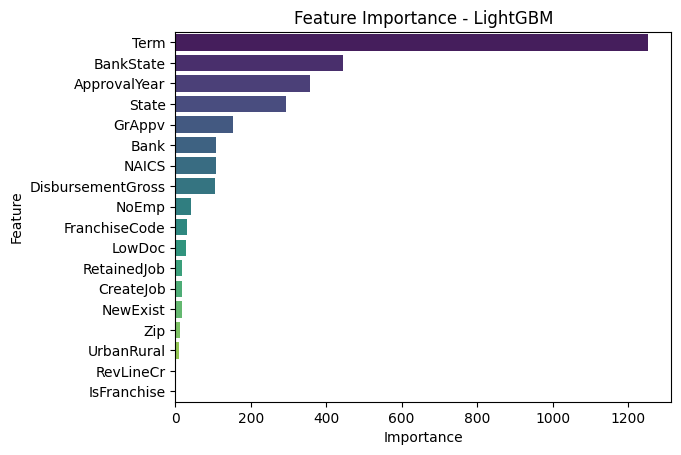

In [90]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()


In [ ]:
#Test with categorisation of NAICS

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Label encoding
label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']
for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=100, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_70556/613333879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/613333879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/613333879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS, categorical_column=0,2,4,5,7,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3106
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> i

In [93]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/3609398526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


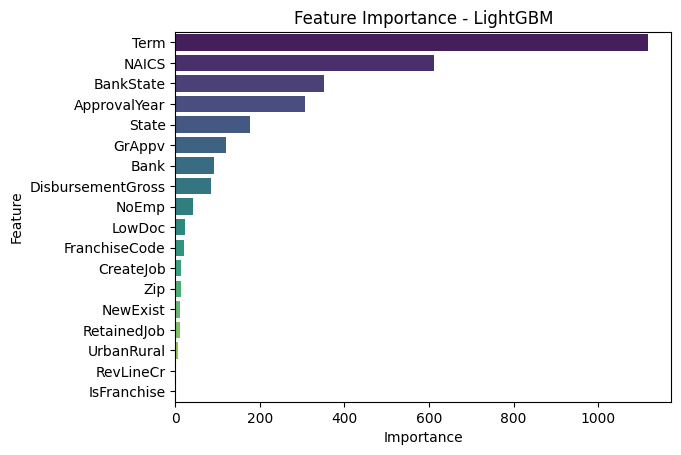

In [94]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()

In [4]:
#Test with categorisation of all

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=100, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/2357742612.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/2357742612.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/2357742612.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightG

In [5]:
print(classification_report(y_test, y_pred_labels))

NameError: name 'y_pred_labels' is not defined

#### Fine tunning

In [6]:
#Gridsearch

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)

param_grid = {
    'n_estimators':[100, 150, 200],
    'learning_rate':[0.1, 0.2, 0.3]
}
grid=GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)


grid.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Result
print(f'best parameters : {grid.best_params_}')
print(f'best score : {grid.best_score_}')
print(f'Score on the entire test : {grid.score(X_test, y_test)}')

/tmp/ipykernel_117114/3924234536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/3924234536.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/3924234536.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in pa

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For cat

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.741875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode[LightGBM] [Info] Number of data points in the train set: 64739

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.622195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.532506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.549782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.639922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.597582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.580316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.585147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.482046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.545647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.536505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.442416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.540455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.509878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.444263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.662998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.546916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.537476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.578748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.578128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.548356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.566368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.570515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.646146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.607225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.589947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824482 -> initscore=1.547014
[LightGBM] [Info] Start training from score 1.547014
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.457410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824482 -> initscore=1.547014
[LightGBM] [Info] Start training from score 1.547014
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1

In [ ]:
#Test with n_estimators = 200

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=200, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/1621750461.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/1621750461.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/1621750461.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.93      0.91      0.92     89917
weighted avg       0.95      0.95      0.95     89917



In [13]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print(f'Best parameters: {study.best_params}')


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-07 15:49:18,580] A new study created in memory with name: no-name-695dcc10-ded5-497f-889f-8f63aae22821
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:49:39,900] Trial 0 finished with value: 0.9061530451272262 and parameters: {'n_estimators': 369, 'learning_rate': 0.027846365856069682, 'num_leaves': 57, 'max_depth': 13, 'subsample': 0.7155995485562359, 'colsample_bytree': 0.6547798599699056}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:49:44,944] Trial 1 finished with value: 0.889944900103596 and parameters: {'n_estimators': 192, 'learning_rate': 0.10756666711765574, 'num_leaves': 99, 'max_depth': 4, 'subsample': 0.7994622046946344, 'colsample_bytree': 0.7308029048333204}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:49:58,656] Trial 2 finished with value: 0.8999509789999145 and parameters: {'n_estimators': 273, 'learning_rate': 0.028325523257323584, 'num_leaves': 85, 'max_depth': 7, 'subsample': 0.8920788260566317, 'colsample_bytree': 0.8464725454369817}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:50:01,856] Trial 3 finished with value: 0.8011952912045012 and parameters: {'n_estimators': 111, 'learning_rate': 0.02595003079633617, 'num_leaves': 31, 'max_depth': 3, 'subsample': 0.8172880535666214, 'colsample_bytree': 0.8108175090949852}. Best is trial 0 with value: 0.9061530451272262.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 15:50:15,782] Trial 4 finished with value: 0.8775264836434801 and parameters: {'n_estimators': 477, 'learning_rate': 0.01998390341274766, 'num_leaves': 36, 'max_depth': 4, 'subsample': 0.6284383549158045, 'colsample_bytree': 0.864412376776055}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:50:41,165] Trial 5 finished with value: 0.9037857054816741 and parameters: {'n_estimators': 366, 'learning_rate': 0.014022151200024004, 'num_leaves': 81, 'max_depth': 13, 'subsample': 0.8416506860569266, 'colsample_bytree': 0.7538343389498017}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:02,650] Trial 6 finished with value: 0.9078812523676845 and parameters: {'n_estimators': 389, 'learning_rate': 0.03620006935517644, 'num_leaves': 46, 'max_depth': 14, 'subsample': 0.9880537596838941, 'colsample_bytree': 0.8921122280040867}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:10,765] Trial 7 finished with value: 0.879607270374698 and parameters: {'n_estimators': 174, 'learning_rate': 0.0208860561049388, 'num_leaves': 28, 'max_depth': 12, 'subsample': 0.9770918998958311, 'colsample_bytree': 0.6900472712887183}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:25,401] Trial 8 finished with value: 0.9061853494402135 and parameters: {'n_estimators': 321, 'learning_rate': 0.05976352199500926, 'num_leaves': 40, 'max_depth': 9, 'subsample': 0.9814002378709473, 'colsample_bytree': 0.7698498085526126}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:51:31,259] Trial 9 finished with value: 0.7159230318546457 and parameters: {'n_estimators': 444, 'learning_rate': 0.011984083013070917, 'num_leaves': 55, 'max_depth': 1, 'subsample': 0.6819961887704549, 'colsample_bytree': 0.7397680460483115}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:57,150] Trial 10 finished with value: 0.9113969489723392 and parameters: {'n_estimators': 411, 'learning_rate': 0.20465056780875407, 'num_leaves': 70, 'max_depth': 15, 'subsample': 0.8979799251170678, 'colsample_bytree': 0.996066133773424}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:52:23,352] Trial 11 finished with value: 0.9109654766501125 and parameters: {'n_estimators': 414, 'learning_rate': 0.25779175941732074, 'num_leaves': 71, 'max_depth': 15, 'subsample': 0.9217013608450743, 'colsample_bytree': 0.9958679594214387}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:52:49,919] Trial 12 finished with value: 0.9107664289709346 and parameters: {'n_estimators': 433, 'learning_rate': 0.2846371441575327, 'num_leaves': 73, 'max_depth': 15, 'subsample': 0.8981202879508426, 'colsample_bytree': 0.9902052318166449}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:11,508] Trial 13 finished with value: 0.910542789381358 and parameters: {'n_estimators': 486, 'learning_rate': 0.2786861955963915, 'num_leaves': 69, 'max_depth': 10, 'subsample': 0.9050304692558299, 'colsample_bytree': 0.9961324670999517}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:25,416] Trial 14 finished with value: 0.9116532381744706 and parameters: {'n_estimators': 301, 'learning_rate': 0.14834026171386322, 'num_leaves': 65, 'max_depth': 10, 'subsample': 0.9288688291454804, 'colsample_bytree': 0.9246766702374872}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:38,129] Trial 15 finished with value: 0.910472231602813 and parameters: {'n_estimators': 279, 'learning_rate': 0.1626599791154231, 'num_leaves': 92, 'max_depth': 10, 'subsample': 0.7605614212632557, 'colsample_bytree': 0.9347126294180422}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:50,434] Trial 16 finished with value: 0.9098340671476205 and parameters: {'n_estimators': 318, 'learning_rate': 0.10574712416945142, 'num_leaves': 62, 'max_depth': 8, 'subsample': 0.8448776887858758, 'colsample_bytree': 0.9293854768439762}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:01,399] Trial 17 finished with value: 0.9115271341741896 and parameters: {'n_estimators': 241, 'learning_rate': 0.15331909668203703, 'num_leaves': 49, 'max_depth': 11, 'subsample': 0.9359108752745865, 'colsample_bytree': 0.9315171949716097}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:10,003] Trial 18 finished with value: 0.903917135984192 and parameters: {'n_estimators': 226, 'learning_rate': 0.0772775133204462, 'num_leaves': 49, 'max_depth': 7, 'subsample': 0.9460311384626422, 'colsample_bytree': 0.9228857963670261}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:19,102] Trial 19 finished with value: 0.9061657387324841 and parameters: {'n_estimators': 245, 'learning_rate': 0.1390001720670246, 'num_leaves': 20, 'max_depth': 11, 'subsample': 0.8567008214368003, 'colsample_bytree': 0.8056140786592534}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 15:54:25,188] Trial 20 finished with value: 0.8901924042522549 and parameters: {'n_estimators': 141, 'learning_rate': 0.04562310461435059, 'num_leaves': 48, 'max_depth': 6, 'subsample': 0.9556569281809866, 'colsample_bytree': 0.9508170932050328}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:41,279] Trial 21 finished with value: 0.9116011505039703 and parameters: {'n_estimators': 333, 'learning_rate': 0.1976511931598284, 'num_leaves': 65, 'max_depth': 12, 'subsample': 0.8750082173148346, 'colsample_bytree': 0.879906784892601}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:56,440] Trial 22 finished with value: 0.913381445414929 and parameters: {'n_estimators': 340, 'learning_rate': 0.14597293005490072, 'num_leaves': 58, 'max_depth': 11, 'subsample': 0.935087518878086, 'colsample_bytree': 0.8869899242998047}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:55:13,184] Trial 23 finished with value: 0.912292370579564 and parameters: {'n_estimators': 347, 'learning_rate': 0.09373043639193333, 'num_leaves': 62, 'max_depth': 12, 'subsample': 0.8633848321139715, 'colsample_bytree': 0.8607907780561214}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:55:29,013] Trial 24 finished with value: 0.9117625673679243 and parameters: {'n_estimators': 351, 'learning_rate': 0.09006237943602878, 'num_leaves': 79, 'max_depth': 10, 'subsample': 0.7794581384796194, 'colsample_bytree': 0.8298134413182894}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:55:43,865] Trial 25 finished with value: 0.9111512080736986 and parameters: {'n_estimators': 354, 'learning_rate': 0.08090374800667269, 'num_leaves': 81, 'max_depth': 9, 'subsample': 0.76972697068283, 'colsample_bytree': 0.8353306956280316}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:56:14,743] Trial 26 finished with value: 0.912183664036444 and parameters: {'n_estimators': 343, 'learning_rate': 0.10397151872392994, 'num_leaves': 77, 'max_depth': -1, 'subsample': 0.7387193705586924, 'colsample_bytree': 0.8304335214828878}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:56:36,067] Trial 27 finished with value: 0.911308648437066 and parameters: {'n_estimators': 274, 'learning_rate': 0.06943232506223021, 'num_leaves': 56, 'max_depth': -1, 'subsample': 0.7293403811298976, 'colsample_bytree': 0.8924191758973675}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:57:15,066] Trial 28 finished with value: 0.9125241725722794 and parameters: {'n_estimators': 390, 'learning_rate': 0.04753989529233664, 'num_leaves': 87, 'max_depth': -1, 'subsample': 0.6458454297932384, 'colsample_bytree': 0.7936620799138767}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:57:34,579] Trial 29 finished with value: 0.9128540281036412 and parameters: {'n_estimators': 382, 'learning_rate': 0.050944558429102976, 'num_leaves': 90, 'max_depth': 13, 'subsample': 0.6071700113515591, 'colsample_bytree': 0.6567085998300766}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 15:57:42,601] Trial 30 finished with value: 0.8529612288329549 and parameters: {'n_estimators': 395, 'learning_rate': 0.04619467763539976, 'num_leaves': 92, 'max_depth': 2, 'subsample': 0.6241822466255337, 'colsample_bytree': 0.609065753883025}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:58:03,124] Trial 31 finished with value: 0.9126228487612597 and parameters: {'n_estimators': 380, 'learning_rate': 0.04752963822892663, 'num_leaves': 90, 'max_depth': 13, 'subsample': 0.6020241782875259, 'colsample_bytree': 0.6871004995908109}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:58:23,259] Trial 32 finished with value: 0.9135982358508352 and parameters: {'n_estimators': 378, 'learning_rate': 0.04994671054490809, 'num_leaves': 99, 'max_depth': 13, 'subsample': 0.6608879132638167, 'colsample_bytree': 0.6939594218797047}. Best is trial 32 with value: 0.9135982358508352.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:58:49,060] Trial 33 finished with value: 0.9122379649575126 and parameters: {'n_estimators': 462, 'learning_rate': 0.03512319814232804, 'num_leaves': 100, 'max_depth': 13, 'subsample': 0.6673352770119606, 'colsample_bytree': 0.6903592294704635}. Best is trial 32 with value: 0.9135982358508352.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:59:07,631] Trial 34 finished with value: 0.9134269612825253 and parameters: {'n_estimators': 376, 'learning_rate': 0.05876572668097509, 'num_leaves': 94, 'max_depth': 13, 'subsample': 0.6065182868994656, 'colsample_bytree': 0.6308567232459344}. Best is trial 32 with value: 0.9135982358508352.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:59:30,547] Trial 35 finished with value: 0.9154263645809413 and parameters: {'n_estimators': 420, 'learning_rate': 0.06224037175185122, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6996041312359067, 'colsample_bytree': 0.6113657142402763}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:59:54,049] Trial 36 finished with value: 0.9147320312536793 and parameters: {'n_estimators': 429, 'learning_rate': 0.06395251190040667, 'num_leaves': 95, 'max_depth': 14, 'subsample': 0.6934170224307954, 'colsample_bytree': 0.6079950633204748}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:00:20,343] Trial 37 finished with value: 0.9123552839043214 and parameters: {'n_estimators': 447, 'learning_rate': 0.03480848633522244, 'num_leaves': 96, 'max_depth': 14, 'subsample': 0.6970887457542719, 'colsample_bytree': 0.6003347356054602}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:00:46,847] Trial 38 finished with value: 0.9149544255425884 and parameters: {'n_estimators': 496, 'learning_rate': 0.05912060947141281, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.6597655147113297, 'colsample_bytree': 0.6223428667827811}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:01:11,672] Trial 39 finished with value: 0.9100876930986335 and parameters: {'n_estimators': 422, 'learning_rate': 0.027691710085276437, 'num_leaves': 85, 'max_depth': 14, 'subsample': 0.7080730159670984, 'colsample_bytree': 0.6512634200106996}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:01:39,456] Trial 40 finished with value: 0.9160970059989049 and parameters: {'n_estimators': 492, 'learning_rate': 0.0677304401558715, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6590550923788405, 'colsample_bytree': 0.7135574824658621}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:02:04,413] Trial 41 finished with value: 0.9151788604322825 and parameters: {'n_estimators': 493, 'learning_rate': 0.0683184763502626, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6532189074310315, 'colsample_bytree': 0.627735560734268}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:02:30,124] Trial 42 finished with value: 0.9153393093463353 and parameters: {'n_estimators': 489, 'learning_rate': 0.06301129710566539, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.6809577096352131, 'colsample_bytree': 0.6294931987632033}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:02:56,581] Trial 43 finished with value: 0.9160201537682222 and parameters: {'n_estimators': 497, 'learning_rate': 0.07184855802564262, 'num_leaves': 86, 'max_depth': 15, 'subsample': 0.6448113319967009, 'colsample_bytree': 0.6331928892049741}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:03:22,045] Trial 44 finished with value: 0.9150331457242721 and parameters: {'n_estimators': 467, 'learning_rate': 0.124427676121033, 'num_leaves': 85, 'max_depth': 15, 'subsample': 0.6383810484720772, 'colsample_bytree': 0.6639891316452375}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:03:48,011] Trial 45 finished with value: 0.914984689254791 and parameters: {'n_estimators': 499, 'learning_rate': 0.07221303956448583, 'num_leaves': 88, 'max_depth': 14, 'subsample': 0.6708702693893416, 'colsample_bytree': 0.7221274258325038}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:04:13,644] Trial 46 finished with value: 0.913061065536174 and parameters: {'n_estimators': 475, 'learning_rate': 0.03754316358381636, 'num_leaves': 100, 'max_depth': 14, 'subsample': 0.7200875341975528, 'colsample_bytree': 0.6393428145262405}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:04:36,966] Trial 47 finished with value: 0.9147433069084863 and parameters: {'n_estimators': 453, 'learning_rate': 0.08262616360266258, 'num_leaves': 83, 'max_depth': 15, 'subsample': 0.6263176186106905, 'colsample_bytree': 0.6723869636186954}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:04:59,138] Trial 48 finished with value: 0.9143218649403991 and parameters: {'n_estimators': 478, 'learning_rate': 0.11932402605768251, 'num_leaves': 95, 'max_depth': 12, 'subsample': 0.683425560506608, 'colsample_bytree': 0.714433254291481}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:05:25,103] Trial 49 finished with value: 0.9133676791587875 and parameters: {'n_estimators': 483, 'learning_rate': 0.03899754193612023, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.8030512737442121, 'colsample_bytree': 0.6396933109989565}. Best is trial 40 with value: 0.9160970059989049.


Best parameters: {'n_estimators': 492, 'learning_rate': 0.0677304401558715, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6590550923788405, 'colsample_bytree': 0.7135574824658621}


Best parameters: {'n_estimators': 492, 'learning_rate': 0.0677304401558715, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6590550923788405, 'colsample_bytree': 0.7135574824658621}

In [16]:
study = optuna.create_study(direction='maximize', study_name="lightgbm_study", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

[I 2025-02-08 23:38:01,607] A new study created in RDB with name: lightgbm_study
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-08 23:38:14,190] Trial 0 finished with value: 0.9091495915247144 and parameters: {'n_estimators': 467, 'learning_rate': 0.260549223180108, 'num_leaves': 56, 'max_depth': 5, 'subsample': 0.7627651547838881, 'colsample_bytree': 0.7094221260978752}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:38:20,541] Trial 1 finished with value: 0.9060808967484465 and parameters: {'n_estimators': 145, 'learning_rate': 0.1395380072949571, 'num_leaves': 97, 'max_depth': 7, 'subsample': 0.9472465424727027, 'colsample_bytree': 0.9845186336934565}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-08 23:38:33,161] Trial 2 finished with value: 0.8407516130553903 and parameters: {'n_estimators': 485, 'learning_rate': 0.012584608806452801, 'num_leaves': 65, 'max_depth': 3, 'subsample': 0.6866013712675312, 'colsample_bytree': 0.7687622774775823}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:38:56,294] Trial 3 finished with value: 0.9075854643993284 and parameters: {'n_estimators': 472, 'learning_rate': 0.03379396203348819, 'num_leaves': 57, 'max_depth': 10, 'subsample': 0.7097000349162936, 'colsample_bytree': 0.6701452199624145}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:39:24,619] Trial 4 finished with value: 0.9115762132940044 and parameters: {'n_estimators': 435, 'learning_rate': 0.21460761087733435, 'num_leaves': 84, 'max_depth': 15, 'subsample': 0.9649941194890069, 'colsample_bytree': 0.8646246529084576}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-08 23:39:32,850] Trial 5 finished with value: 0.887770486334868 and parameters: {'n_estimators': 305, 'learning_rate': 0.05631836344538564, 'num_leaves': 73, 'max_depth': 4, 'subsample': 0.9529105455620263, 'colsample_bytree': 0.7124095211517159}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:39:39,282] Trial 6 finished with value: 0.8377044648866536 and parameters: {'n_estimators': 124, 'learning_rate': 0.014297896594491676, 'num_leaves': 25, 'max_depth': 12, 'subsample': 0.8943704758429343, 'colsample_bytree': 0.962289554237545}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:39:52,638] Trial 7 finished with value: 0.9100382686792514 and parameters: {'n_estimators': 406, 'learning_rate': 0.13536607949205898, 'num_leaves': 37, 'max_depth': 7, 'subsample': 0.8494555574543381, 'colsample_bytree': 0.8297986245481741}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:40:07,053] Trial 8 finished with value: 0.9097521657654677 and parameters: {'n_estimators': 363, 'learning_rate': 0.20202760177396775, 'num_leaves': 36, 'max_depth': 9, 'subsample': 0.955738951463453, 'colsample_bytree': 0.858004760817057}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:40:23,098] Trial 9 finished with value: 0.9042838270306603 and parameters: {'n_estimators': 480, 'learning_rate': 0.0627794835650174, 'num_leaves': 43, 'max_depth': 6, 'subsample': 0.7988227948282719, 'colsample_bytree': 0.9279199042973139}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:40:38,390] Trial 10 finished with value: 0.9146335277144826 and parameters: {'n_estimators': 249, 'learning_rate': 0.09364585488462915, 'num_leaves': 92, 'max_depth': 15, 'subsample': 0.8685500014006472, 'colsample_bytree': 0.6116403199097216}. Best is trial 10 with value: 0.9146335277144826.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:40:51,250] Trial 11 finished with value: 0.9146699132290392 and parameters: {'n_estimators': 223, 'learning_rate': 0.09286389146577943, 'num_leaves': 95, 'max_depth': 15, 'subsample': 0.609165663727415, 'colsample_bytree': 0.6176658406858786}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:04,014] Trial 12 finished with value: 0.9145431865784246 and parameters: {'n_estimators': 207, 'learning_rate': 0.10790344944531602, 'num_leaves': 99, 'max_depth': 15, 'subsample': 0.603625642588776, 'colsample_bytree': 0.603664300642037}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:22,317] Trial 13 finished with value: 0.9076751828850526 and parameters: {'n_estimators': 237, 'learning_rate': 0.03344858733484344, 'num_leaves': 82, 'max_depth': -1, 'subsample': 0.6008407279599473, 'colsample_bytree': 0.6036493196749777}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:35,959] Trial 14 finished with value: 0.9134512758421577 and parameters: {'n_estimators': 254, 'learning_rate': 0.07913973896845326, 'num_leaves': 88, 'max_depth': 13, 'subsample': 0.8717650626650654, 'colsample_bytree': 0.6581394430264711}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:47,843] Trial 15 finished with value: 0.9045918586037246 and parameters: {'n_estimators': 179, 'learning_rate': 0.0337376050597447, 'num_leaves': 71, 'max_depth': 12, 'subsample': 0.6687013504140611, 'colsample_bytree': 0.7620569126076758}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:04,205] Trial 16 finished with value: 0.9147124205459499 and parameters: {'n_estimators': 294, 'learning_rate': 0.09807437404169007, 'num_leaves': 90, 'max_depth': 15, 'subsample': 0.7544074136196353, 'colsample_bytree': 0.6622117549971428}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:21,763] Trial 17 finished with value: 0.9101496384734898 and parameters: {'n_estimators': 318, 'learning_rate': 0.04431392931758467, 'num_leaves': 77, 'max_depth': 13, 'subsample': 0.7395023815079061, 'colsample_bytree': 0.6732980211175374}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:43,223] Trial 18 finished with value: 0.9068905084217326 and parameters: {'n_estimators': 348, 'learning_rate': 0.021809352735003663, 'num_leaves': 100, 'max_depth': 10, 'subsample': 0.6504171280313705, 'colsample_bytree': 0.7320328599569746}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:42:47,328] Trial 19 finished with value: 0.7989563790663436 and parameters: {'n_estimators': 272, 'learning_rate': 0.13424047014615254, 'num_leaves': 91, 'max_depth': 1, 'subsample': 0.8057247331130278, 'colsample_bytree': 0.6482868576806652}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:56,856] Trial 20 finished with value: 0.905739142911944 and parameters: {'n_estimators': 191, 'learning_rate': 0.06831261594580211, 'num_leaves': 65, 'max_depth': 9, 'subsample': 0.7377691926479162, 'colsample_bytree': 0.7866891263185385}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:09,818] Trial 21 finished with value: 0.9142284105526728 and parameters: {'n_estimators': 229, 'learning_rate': 0.0952196878855131, 'num_leaves': 91, 'max_depth': 15, 'subsample': 0.9036274271347146, 'colsample_bytree': 0.6279955971225979}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:24,184] Trial 22 finished with value: 0.9128990260218866 and parameters: {'n_estimators': 275, 'learning_rate': 0.09246234045158858, 'num_leaves': 80, 'max_depth': 13, 'subsample': 0.8216174265615743, 'colsample_bytree': 0.690488741783313}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:33,186] Trial 23 finished with value: 0.9140577586346963 and parameters: {'n_estimators': 163, 'learning_rate': 0.16271849620239395, 'num_leaves': 93, 'max_depth': 14, 'subsample': 0.8416124336142929, 'colsample_bytree': 0.6278795823038105}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:48,533] Trial 24 finished with value: 0.9134235027312896 and parameters: {'n_estimators': 337, 'learning_rate': 0.10570982267304106, 'num_leaves': 86, 'max_depth': 11, 'subsample': 0.9995353130033038, 'colsample_bytree': 0.6412475719074089}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:57,302] Trial 25 finished with value: 0.9046875262420193 and parameters: {'n_estimators': 103, 'learning_rate': 0.04746726917240652, 'num_leaves': 95, 'max_depth': 14, 'subsample': 0.6357289988383771, 'colsample_bytree': 0.7378384425380231}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:12,418] Trial 26 finished with value: 0.9117652306190426 and parameters: {'n_estimators': 281, 'learning_rate': 0.08180205440562976, 'num_leaves': 49, 'max_depth': 15, 'subsample': 0.7833005126329498, 'colsample_bytree': 0.6102257579369177}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:30,530] Trial 27 finished with value: 0.911417804980736 and parameters: {'n_estimators': 380, 'learning_rate': 0.29964496052928113, 'num_leaves': 75, 'max_depth': 12, 'subsample': 0.7617025298270459, 'colsample_bytree': 0.6844495533563084}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:43,964] Trial 28 finished with value: 0.9142613375159937 and parameters: {'n_estimators': 229, 'learning_rate': 0.1735158246338448, 'num_leaves': 87, 'max_depth': 14, 'subsample': 0.9101151354276251, 'colsample_bytree': 0.6413108178475516}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:53,937] Trial 29 finished with value: 0.9111632790286232 and parameters: {'n_estimators': 207, 'learning_rate': 0.1127457609464298, 'num_leaves': 62, 'max_depth': 11, 'subsample': 0.7055496642474491, 'colsample_bytree': 0.7087563236840209}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:08,191] Trial 30 finished with value: 0.9109801061551726 and parameters: {'n_estimators': 316, 'learning_rate': 0.07466975729920557, 'num_leaves': 69, 'max_depth': 9, 'subsample': 0.7614039334979941, 'colsample_bytree': 0.696622615601057}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:20,849] Trial 31 finished with value: 0.9149853119051249 and parameters: {'n_estimators': 211, 'learning_rate': 0.13407088431875822, 'num_leaves': 100, 'max_depth': 15, 'subsample': 0.6000797655700635, 'colsample_bytree': 0.6007054420832634}. Best is trial 31 with value: 0.9149853119051249.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:29,896] Trial 32 finished with value: 0.9134517258427077 and parameters: {'n_estimators': 161, 'learning_rate': 0.13700212251086372, 'num_leaves': 95, 'max_depth': 14, 'subsample': 0.6330152969186933, 'colsample_bytree': 0.6018351656551191}. Best is trial 31 with value: 0.9149853119051249.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:43,729] Trial 33 finished with value: 0.9136275316131369 and parameters: {'n_estimators': 253, 'learning_rate': 0.24196390422224875, 'num_leaves': 99, 'max_depth': 15, 'subsample': 0.6230010479045246, 'colsample_bytree': 0.6281688472667567}. Best is trial 31 with value: 0.9149853119051249.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:54,982] Trial 34 finished with value: 0.9150634094364748 and parameters: {'n_estimators': 207, 'learning_rate': 0.1691751662861345, 'num_leaves': 92, 'max_depth': 13, 'subsample': 0.673641806078744, 'colsample_bytree': 0.6620831506071774}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:05,293] Trial 35 finished with value: 0.9131308280146018 and parameters: {'n_estimators': 205, 'learning_rate': 0.1756656259083393, 'num_leaves': 81, 'max_depth': 13, 'subsample': 0.6741547414598689, 'colsample_bytree': 0.6637928197924852}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:12,675] Trial 36 finished with value: 0.9097545516658195 and parameters: {'n_estimators': 135, 'learning_rate': 0.1226289747023605, 'num_leaves': 88, 'max_depth': 11, 'subsample': 0.7000091782801222, 'colsample_bytree': 0.7316540906879163}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:27,496] Trial 37 finished with value: 0.913172540031395 and parameters: {'n_estimators': 287, 'learning_rate': 0.21337632067756737, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6602098416980706, 'colsample_bytree': 0.6633569558541964}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:36,184] Trial 38 finished with value: 0.9119068641254835 and parameters: {'n_estimators': 158, 'learning_rate': 0.15204079993110936, 'num_leaves': 78, 'max_depth': 12, 'subsample': 0.7254449134211673, 'colsample_bytree': 0.7512865691921552}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:46:40,598] Trial 39 finished with value: 0.8602401941397244 and parameters: {'n_estimators': 182, 'learning_rate': 0.05646558566282131, 'num_leaves': 85, 'max_depth': 3, 'subsample': 0.6896589820860836, 'colsample_bytree': 0.8139893912541718}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:46:50,199] Trial 40 finished with value: 0.9108154033897665 and parameters: {'n_estimators': 218, 'learning_rate': 0.19084665483485388, 'num_leaves': 100, 'max_depth': 8, 'subsample': 0.619913977181323, 'colsample_bytree': 0.9073163704267965}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:04,491] Trial 41 finished with value: 0.9144912715577079 and parameters: {'n_estimators': 252, 'learning_rate': 0.09235828717691563, 'num_leaves': 92, 'max_depth': 15, 'subsample': 0.6406149802970635, 'colsample_bytree': 0.6236382118898195}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:17,274] Trial 42 finished with value: 0.9138306604938841 and parameters: {'n_estimators': 244, 'learning_rate': 0.12114874001620664, 'num_leaves': 91, 'max_depth': 14, 'subsample': 0.6142723815150769, 'colsample_bytree': 0.6372819440501174}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:34,509] Trial 43 finished with value: 0.9136457243704152 and parameters: {'n_estimators': 300, 'learning_rate': 0.2528413523270134, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.6770128260455169, 'colsample_bytree': 0.6160709987638704}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:45,473] Trial 44 finished with value: 0.910688676739152 and parameters: {'n_estimators': 268, 'learning_rate': 0.1519376998733867, 'num_leaves': 25, 'max_depth': 13, 'subsample': 0.9214291600873197, 'colsample_bytree': 0.674212698485696}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:57,339] Trial 45 finished with value: 0.9120133574180351 and parameters: {'n_estimators': 191, 'learning_rate': 0.08562961740816549, 'num_leaves': 83, 'max_depth': 15, 'subsample': 0.8579057943555091, 'colsample_bytree': 0.7121624072866991}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:48:04,872] Trial 46 finished with value: 0.8926858478980877 and parameters: {'n_estimators': 221, 'learning_rate': 0.06488472588634688, 'num_leaves': 51, 'max_depth': 5, 'subsample': 0.6486438155495087, 'colsample_bytree': 0.6507671095516836}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:48:20,773] Trial 47 finished with value: 0.9148303621430922 and parameters: {'n_estimators': 297, 'learning_rate': 0.104609552695418, 'num_leaves': 89, 'max_depth': 13, 'subsample': 0.8767981146103552, 'colsample_bytree': 0.6015217779155184}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:48:41,156] Trial 48 finished with value: 0.9148485549003705 and parameters: {'n_estimators': 423, 'learning_rate': 0.10659512160049701, 'num_leaves': 90, 'max_depth': 12, 'subsample': 0.6074775184671554, 'colsample_bytree': 0.6827842228518527}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:49:08,794] Trial 49 finished with value: 0.9019610353028038 and parameters: {'n_estimators': 428, 'learning_rate': 0.011787881446552033, 'num_leaves': 89, 'max_depth': 10, 'subsample': 0.7223945272197358, 'colsample_bytree': 0.6981979822041299}. Best is trial 34 with value: 0.9150634094364748.


In [14]:
#Test with best estimators

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=255, learning_rate=0.0677304401558715,num_leaves=97,max_depth=14, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.6590550923788405, colsample_bytree=0.7135574824658621, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/2333577477.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/2333577477.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/2333577477.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightG

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.96     89917
   macro avg       0.93      0.91      0.92     89917
weighted avg       0.95      0.96      0.96     89917



/tmp/ipykernel_117114/3609398526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


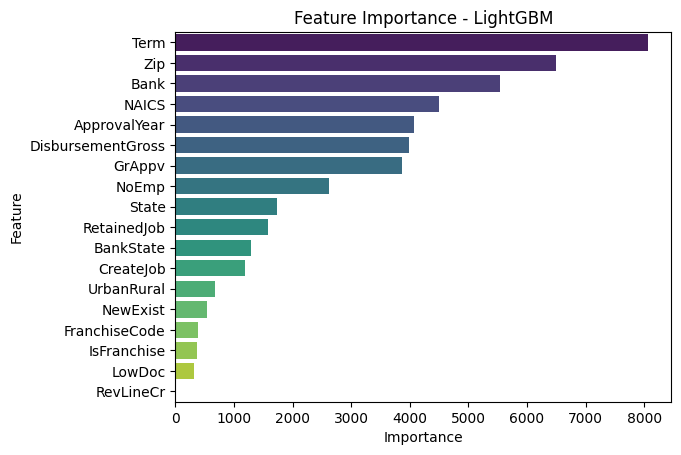

In [17]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()

In [19]:
#Test without the RevLineCr

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=255, learning_rate=0.0677304401558715,num_leaves=97,max_depth=14, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.6590550923788405, colsample_bytree=0.7135574824658621, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/983270419.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/983270419.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/983270419.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:Boos

In [20]:
#Test without ZIP and Revline = lightgbm_study2

#features 
features = ['State','UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
             'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise',  'LowDoc', 'NAICS', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=255, learning_rate=0.0677304401558715,num_leaves=97,max_depth=14, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.6590550923788405, colsample_bytree=0.7135574824658621, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/4161322124.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/4161322124.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/4161322124.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode, categorical_column=0,1,2,3,4,6,9,10,12 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5484
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]:

/tmp/ipykernel_117114/3609398526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


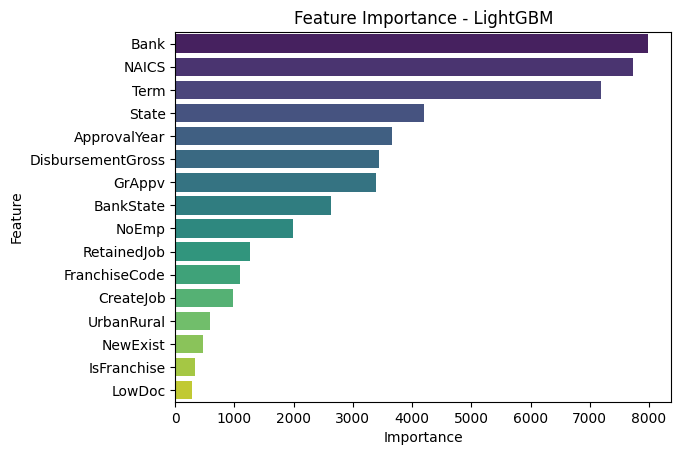

In [21]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()

In [22]:
study = optuna.create_study(direction='maximize', study_name="lightgbm_study2", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

[I 2025-02-10 12:17:37,781] A new study created in RDB with name: lightgbm_study2
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:17:45,510] Trial 0 finished with value: 0.8607059746235417 and parameters: {'n_estimators': 177, 'learning_rate': 0.012446119408476298, 'num_leaves': 47, 'max_depth': -1, 'subsample': 0.793682718862466, 'colsample_bytree': 0.6051763861145533}. Best is trial 0 with value: 0.8607059746235417.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-02-10 12:17:51,377] Trial 1 finished with value: 0.8846732231476147 and parameters: {'n_estimators': 189, 'learning_rate': 0.03768594626723131, 'num_leaves': 49, 'max_depth': 5, 'subsample': 0.9552003560337368, 'colsample_bytree': 0.857203772687952}. Best is trial 1 with value: 0.8846732231476147.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 12:17:58,122] Trial 2 finished with value: 0.889556730398397 and parameters: {'n_estimators': 234, 'learning_rate': 0.043657822787254524, 'num_leaves': 22, 'max_depth': 5, 'subsample': 0.605513825114137, 'colsample_bytree': 0.6214542920983337}. Best is trial 2 with value: 0.889556730398397.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:18:02,715] Trial 3 finished with value: 0.9103759413141846 and parameters: {'n_estimators': 109, 'learning_rate': 0.11357178572095027, 'num_leaves': 41, 'max_depth': 15, 'subsample': 0.9589020756253391, 'colsample_bytree': 0.6995951306862438}. Best is trial 3 with value: 0.9103759413141846.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:18:16,264] Trial 4 finished with value: 0.8927330590669013 and parameters: {'n_estimators': 360, 'learning_rate': 0.01453791866098111, 'num_leaves': 51, 'max_depth': 7, 'subsample': 0.9343643330521634, 'colsample_bytree': 0.6139625579055116}. Best is trial 3 with value: 0.9103759413141846.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:18:26,189] Trial 5 finished with value: 0.9127399950582845 and parameters: {'n_estimators': 220, 'learning_rate': 0.0598339291080115, 'num_leaves': 48, 'max_depth': -1, 'subsample': 0.8682224434331153, 'colsample_bytree': 0.8108080871611916}. Best is trial 5 with value: 0.9127399950582845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:18:33,271] Trial 6 finished with value: 0.9112732308724104 and parameters: {'n_estimators': 140, 'learning_rate': 0.07492358868015589, 'num_leaves': 67, 'max_depth': 14, 'subsample': 0.7277360615365317, 'colsample_bytree': 0.8559435934245327}. Best is trial 5 with value: 0.9127399950582845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:18:50,524] Trial 7 finished with value: 0.8956138771178155 and parameters: {'n_estimators': 382, 'learning_rate': 0.010015659060732426, 'num_leaves': 88, 'max_depth': 8, 'subsample': 0.8486134616917247, 'colsample_bytree': 0.9122156062212123}. Best is trial 5 with value: 0.9127399950582845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:18:59,719] Trial 8 finished with value: 0.8733115404576948 and parameters: {'n_estimators': 189, 'learning_rate': 0.012620382068234771, 'num_leaves': 97, 'max_depth': 9, 'subsample': 0.7115338390318807, 'colsample_bytree': 0.6156048878253887}. Best is trial 5 with value: 0.9127399950582845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-10 12:19:11,121] Trial 9 finished with value: 0.911186348287588 and parameters: {'n_estimators': 479, 'learning_rate': 0.11099734454633503, 'num_leaves': 100, 'max_depth': 5, 'subsample': 0.659943294013316, 'colsample_bytree': 0.6214853430873823}. Best is trial 5 with value: 0.9127399950582845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:19:21,331] Trial 10 finished with value: 0.9178040119313993 and parameters: {'n_estimators': 274, 'learning_rate': 0.29028367651523296, 'num_leaves': 70, 'max_depth': -1, 'subsample': 0.8573895957484329, 'colsample_bytree': 0.7625183000459694}. Best is trial 10 with value: 0.9178040119313993.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:19:32,370] Trial 11 finished with value: 0.9160682649381359 and parameters: {'n_estimators': 297, 'learning_rate': 0.2602824271334776, 'num_leaves': 71, 'max_depth': -1, 'subsample': 0.8667183244376405, 'colsample_bytree': 0.7550334069524786}. Best is trial 10 with value: 0.9178040119313993.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-02-10 12:19:36,285] Trial 12 finished with value: 0.843866415152969 and parameters: {'n_estimators': 296, 'learning_rate': 0.2962994078075144, 'num_leaves': 72, 'max_depth': 1, 'subsample': 0.8653857259333099, 'colsample_bytree': 0.7261117904054164}. Best is trial 10 with value: 0.9178040119313993.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-10 12:19:40,511] Trial 13 finished with value: 0.8938992634837152 and parameters: {'n_estimators': 304, 'learning_rate': 0.2918797216790794, 'num_leaves': 79, 'max_depth': 2, 'subsample': 0.781155997698645, 'colsample_bytree': 0.7491775495754758}. Best is trial 10 with value: 0.9178040119313993.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-10 12:19:44,532] Trial 14 finished with value: 0.8805060825843573 and parameters: {'n_estimators': 282, 'learning_rate': 0.17426706837801784, 'num_leaves': 62, 'max_depth': 2, 'subsample': 0.9041184820772195, 'colsample_bytree': 0.7782007306387593}. Best is trial 10 with value: 0.9178040119313993.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:19:57,191] Trial 15 finished with value: 0.9188314866914751 and parameters: {'n_estimators': 367, 'learning_rate': 0.1827344822782273, 'num_leaves': 80, 'max_depth': 11, 'subsample': 0.9982268137896761, 'colsample_bytree': 0.9574033752488582}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:20:12,012] Trial 16 finished with value: 0.9181446931170181 and parameters: {'n_estimators': 417, 'learning_rate': 0.16886091095325131, 'num_leaves': 83, 'max_depth': 11, 'subsample': 0.99641580538356, 'colsample_bytree': 0.980953028647734}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:20:29,120] Trial 17 finished with value: 0.9171208495579614 and parameters: {'n_estimators': 464, 'learning_rate': 0.15534127578781312, 'num_leaves': 84, 'max_depth': 12, 'subsample': 0.996022633807584, 'colsample_bytree': 0.9804877549086237}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:20:46,826] Trial 18 finished with value: 0.912128635764059 and parameters: {'n_estimators': 415, 'learning_rate': 0.026917417514727746, 'num_leaves': 87, 'max_depth': 11, 'subsample': 0.9922936966821376, 'colsample_bytree': 0.99949751751422}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:20:59,429] Trial 19 finished with value: 0.918406308821386 and parameters: {'n_estimators': 350, 'learning_rate': 0.1750874424257728, 'num_leaves': 78, 'max_depth': 11, 'subsample': 0.9198133733089131, 'colsample_bytree': 0.9370677322110579}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:21:14,480] Trial 20 finished with value: 0.9184690494963597 and parameters: {'n_estimators': 363, 'learning_rate': 0.09648770413236855, 'num_leaves': 94, 'max_depth': 13, 'subsample': 0.9121170641709057, 'colsample_bytree': 0.9377766355767722}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:21:28,966] Trial 21 finished with value: 0.918698983538074 and parameters: {'n_estimators': 348, 'learning_rate': 0.10424205767346244, 'num_leaves': 95, 'max_depth': 13, 'subsample': 0.9155692504641918, 'colsample_bytree': 0.9334450952785219}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:21:43,108] Trial 22 finished with value: 0.9182991928785007 and parameters: {'n_estimators': 339, 'learning_rate': 0.09738915182031462, 'num_leaves': 94, 'max_depth': 13, 'subsample': 0.9158275354941922, 'colsample_bytree': 0.9272262179187082}. Best is trial 15 with value: 0.9188314866914751.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:22:00,875] Trial 23 finished with value: 0.919281324420764 and parameters: {'n_estimators': 410, 'learning_rate': 0.07346469446007273, 'num_leaves': 92, 'max_depth': 15, 'subsample': 0.957677243607746, 'colsample_bytree': 0.8864944352624731}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:22:20,209] Trial 24 finished with value: 0.9184394084344907 and parameters: {'n_estimators': 411, 'learning_rate': 0.06720448174078912, 'num_leaves': 91, 'max_depth': 15, 'subsample': 0.9593145884489123, 'colsample_bytree': 0.878568691707982}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:22:35,053] Trial 25 finished with value: 0.9182311257012904 and parameters: {'n_estimators': 387, 'learning_rate': 0.13978413777265383, 'num_leaves': 100, 'max_depth': 10, 'subsample': 0.8259586372522532, 'colsample_bytree': 0.893418456275751}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:22:53,389] Trial 26 finished with value: 0.918597816747759 and parameters: {'n_estimators': 449, 'learning_rate': 0.08300568754390902, 'num_leaves': 80, 'max_depth': 13, 'subsample': 0.9660995347750475, 'colsample_bytree': 0.825885883060481}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:23:08,070] Trial 27 finished with value: 0.9156310161131223 and parameters: {'n_estimators': 328, 'learning_rate': 0.051761698649793346, 'num_leaves': 75, 'max_depth': 15, 'subsample': 0.8898841938443145, 'colsample_bytree': 0.9509257956125167}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:23:24,806] Trial 28 finished with value: 0.9171409102662408 and parameters: {'n_estimators': 494, 'learning_rate': 0.2251077963499942, 'num_leaves': 90, 'max_depth': 14, 'subsample': 0.9399540766460982, 'colsample_bytree': 0.9560290511958125}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:23:38,786] Trial 29 finished with value: 0.9180921554459678 and parameters: {'n_estimators': 431, 'learning_rate': 0.12897942684316316, 'num_leaves': 60, 'max_depth': 12, 'subsample': 0.7990370291037676, 'colsample_bytree': 0.8974229248636143}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:23:49,133] Trial 30 finished with value: 0.9172028556410969 and parameters: {'n_estimators': 387, 'learning_rate': 0.2141612571555359, 'num_leaves': 40, 'max_depth': 9, 'subsample': 0.9776625720795368, 'colsample_bytree': 0.8611314732206451}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:24:06,686] Trial 31 finished with value: 0.9187629695137148 and parameters: {'n_estimators': 440, 'learning_rate': 0.08024276805209898, 'num_leaves': 83, 'max_depth': 13, 'subsample': 0.965878130656979, 'colsample_bytree': 0.8225049262559835}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:24:23,678] Trial 32 finished with value: 0.9190630113334242 and parameters: {'n_estimators': 439, 'learning_rate': 0.08709810764948776, 'num_leaves': 85, 'max_depth': 14, 'subsample': 0.9418521207351286, 'colsample_bytree': 0.8280520042355323}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:24:42,493] Trial 33 finished with value: 0.916091679496668 and parameters: {'n_estimators': 444, 'learning_rate': 0.037819525356311945, 'num_leaves': 85, 'max_depth': 14, 'subsample': 0.9475465164896415, 'colsample_bytree': 0.8350934276985793}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:24:59,586] Trial 34 finished with value: 0.917178886381032 and parameters: {'n_estimators': 466, 'learning_rate': 0.052502802051598164, 'num_leaves': 64, 'max_depth': 12, 'subsample': 0.9783664540175262, 'colsample_bytree': 0.7984032183150319}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:25:17,715] Trial 35 finished with value: 0.9138502712016136 and parameters: {'n_estimators': 398, 'learning_rate': 0.03180212180390619, 'num_leaves': 75, 'max_depth': 15, 'subsample': 0.9410735667386656, 'colsample_bytree': 0.8482379195740045}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:25:34,536] Trial 36 finished with value: 0.9187386549540826 and parameters: {'n_estimators': 437, 'learning_rate': 0.0853720897841915, 'num_leaves': 82, 'max_depth': 14, 'subsample': 0.8858870808045637, 'colsample_bytree': 0.8779833501889719}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-10 12:25:44,429] Trial 37 finished with value: 0.9040129762722701 and parameters: {'n_estimators': 376, 'learning_rate': 0.043609264730244394, 'num_leaves': 90, 'max_depth': 6, 'subsample': 0.9792695733353189, 'colsample_bytree': 0.7995133912381952}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:25:59,670] Trial 38 finished with value: 0.9125823820451335 and parameters: {'n_estimators': 500, 'learning_rate': 0.06455489911054499, 'num_leaves': 25, 'max_depth': 10, 'subsample': 0.7732493288757702, 'colsample_bytree': 0.8234015607769971}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:26:22,823] Trial 39 finished with value: 0.912368600159913 and parameters: {'n_estimators': 461, 'learning_rate': 0.02229283191091464, 'num_leaves': 76, 'max_depth': 14, 'subsample': 0.6068868947852183, 'colsample_bytree': 0.906493984690038}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:26:32,851] Trial 40 finished with value: 0.9165317642225836 and parameters: {'n_estimators': 327, 'learning_rate': 0.12483128633240448, 'num_leaves': 57, 'max_depth': 8, 'subsample': 0.8324547558490052, 'colsample_bytree': 0.6683634626706801}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:26:49,759] Trial 41 finished with value: 0.9190885711937238 and parameters: {'n_estimators': 433, 'learning_rate': 0.08321145938821771, 'num_leaves': 82, 'max_depth': 15, 'subsample': 0.8879812283632849, 'colsample_bytree': 0.8726008870862301}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:27:09,012] Trial 42 finished with value: 0.9187676733656178 and parameters: {'n_estimators': 423, 'learning_rate': 0.07493442445831046, 'num_leaves': 87, 'max_depth': 15, 'subsample': 0.933279746946286, 'colsample_bytree': 0.8684247674552974}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:27:27,123] Trial 43 finished with value: 0.9180706767872374 and parameters: {'n_estimators': 408, 'learning_rate': 0.0672343494709676, 'num_leaves': 87, 'max_depth': 15, 'subsample': 0.9336929338128812, 'colsample_bytree': 0.8726431261847756}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:27:44,902] Trial 44 finished with value: 0.9178773009098635 and parameters: {'n_estimators': 428, 'learning_rate': 0.053548066862429904, 'num_leaves': 91, 'max_depth': 14, 'subsample': 0.8879946073726701, 'colsample_bytree': 0.8515312531533036}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:28:04,606] Trial 45 finished with value: 0.9166253912600936 and parameters: {'n_estimators': 480, 'learning_rate': 0.04350842443957842, 'num_leaves': 70, 'max_depth': 15, 'subsample': 0.9312980497185905, 'colsample_bytree': 0.9164904900758728}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:28:19,347] Trial 46 finished with value: 0.9181698029767678 and parameters: {'n_estimators': 370, 'learning_rate': 0.07319794591112232, 'num_leaves': 97, 'max_depth': 12, 'subsample': 0.9554041106081651, 'colsample_bytree': 0.8830864908471161}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:28:29,506] Trial 47 finished with value: 0.9164373418849563 and parameters: {'n_estimators': 245, 'learning_rate': 0.09210608897721226, 'num_leaves': 55, 'max_depth': 14, 'subsample': 0.7465775893289092, 'colsample_bytree': 0.8489059097451206}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:28:43,567] Trial 48 finished with value: 0.9181925269361655 and parameters: {'n_estimators': 399, 'learning_rate': 0.11974238771867848, 'num_leaves': 67, 'max_depth': 15, 'subsample': 0.8980439325334679, 'colsample_bytree': 0.8625963593097519}. Best is trial 23 with value: 0.919281324420764.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5479
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 12:29:01,525] Trial 49 finished with value: 0.9171149004053911 and parameters: {'n_estimators': 451, 'learning_rate': 0.06081595771569891, 'num_leaves': 79, 'max_depth': 13, 'subsample': 0.8416063867953316, 'colsample_bytree': 0.7879954171847596}. Best is trial 23 with value: 0.919281324420764.


In [26]:
#Test without ZIP and Revline = lightgbm_study2

#features 
features = ['State','UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
             'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise',  'LowDoc', 'NAICS', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=451, learning_rate=0.06081595771569891,num_leaves=79,max_depth=13, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.8416063867953316, colsample_bytree=0.7879954171847596, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/3337719184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/3337719184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/3337719184.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode, categorical_column=0,1,2,3,4,6,9,10,12 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5960
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]:

/tmp/ipykernel_117114/3609398526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


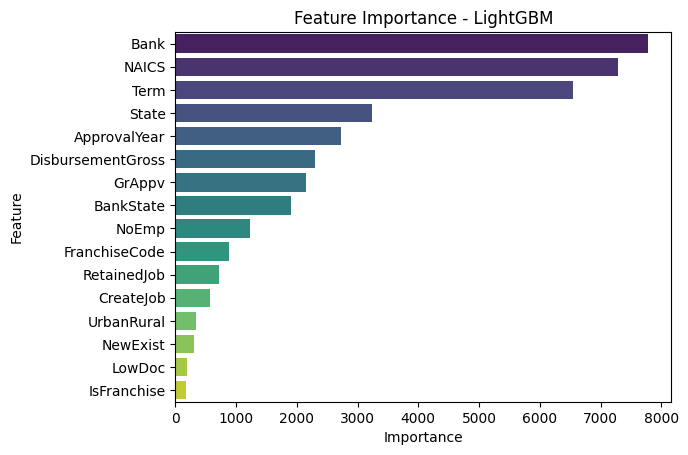

In [24]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()

So weird that Term part came in third position... Propose that we continue with Zip code, but trash RevLineCr(don't seem to be important)

In [ ]:
#Testavec un scaler

#features 
features = ['State','Zip','UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
             'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'Zip', 'NewExist', 'IsFranchise',  'LowDoc', 'NAICS', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")

# Selecion of the variables to scale
continuous_cols = ['Term', 'DisbursementGross', 'GrAppv']

# Scaling of vzlues
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=451, learning_rate=0.06081595771569891,num_leaves=79,max_depth=13, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.8416063867953316, colsample_bytree=0.7879954171847596, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/3287738226.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/3287738226.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/3287738226.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,Zip,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,Zip,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18737
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:Boos

In [36]:
#Testavec un robustscaler

#features 
features = ['State','Zip','UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
             'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'Zip', 'NewExist', 'IsFranchise',  'LowDoc', 'NAICS', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")

# Selecion of the variables to scale
continuous_cols = ['Term', 'DisbursementGross', 'GrAppv']

# Scaling of vzlues
scaler = RobustScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=451, learning_rate=0.06081595771569891,num_leaves=79,max_depth=13, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.8416063867953316, colsample_bytree=0.7879954171847596, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/544087581.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/544087581.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/544087581.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,Zip,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,Zip,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18736
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:Boos

/tmp/ipykernel_117114/3609398526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


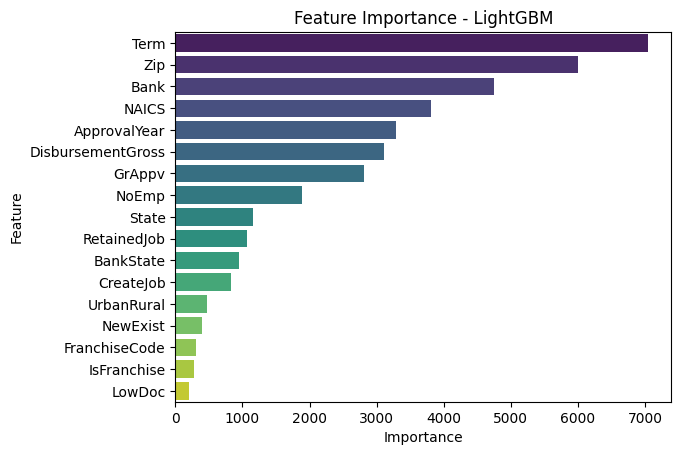

In [37]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()

In [34]:
df

,MIS_Status,LoanNr_ChkDgt,State,Zip,UrbanRural,Bank,BankState,NAICS,NoEmp,NewExist,...,FranchiseCode,IsFranchise,Term,RevLineCr,LowDoc,DisbursementGross,ApprovalDate,ApprovalFY,GrAppv,SBA_Appv
0,1,1000014003,IN,47711,0,FIFTH THIRD BANK,OH,451120,4,2.0,...,1,1,84,0,1,60000.0,1997-02-28,1997,60000.0,48000.0
1,1,1000024006,IN,46526,0,1ST SOURCE BANK,IN,722410,2,2.0,...,1,1,60,0,1,40000.0,1997-02-28,1997,40000.0,32000.0
2,1,1000034009,IN,47401,0,GRANT COUNTY STATE BANK,IN,621210,7,1.0,...,1,1,180,0,0,287000.0,1997-02-28,1997,287000.0,215250.0
3,1,1000044001,OK,74012,0,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,...,1,1,60,0,1,35000.0,1997-02-28,1997,35000.0,28000.0
4,1,1000054004,FL,32801,0,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,...,1,1,240,0,0,229000.0,1997-02-28,1997,229000.0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,1,9995573004,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,6,1.0,...,1,1,60,0,0,70000.0,1997-02-27,1997,70000.0,56000.0
899160,1,9995603000,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,6,1.0,...,1,1,60,0,0,85000.0,1997-02-27,1997,85000.0,42500.0
899161,1,9995613003,CA,93455,0,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,26,1.0,...,1,1,108,0,0,300000.0,1997-02-27,1997,300000.0,225000.0
899162,0,9995973006,HI,96830,0,BANK OF HAWAII,HI,0,6,1.0,...,1,1,60,0,1,75000.0,1997-02-27,1997,75000.0,60000.0


In [38]:

#features 
features = ['State','Zip','UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
             'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'Zip', 'NewExist', 'IsFranchise',  'LowDoc', 'NAICS', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=451, learning_rate=0.06081595771569891,num_leaves=79,max_depth=13, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.8416063867953316, colsample_bytree=0.7879954171847596, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/3361726265.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/3361726265.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/3361726265.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,Zip,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,Zip,NewExist,IsFranchise,LowDoc,NAICS,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18736
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Inf

In [40]:
df

,MIS_Status,LoanNr_ChkDgt,State,Zip,UrbanRural,Bank,BankState,NAICS,NoEmp,NewExist,...,FranchiseCode,IsFranchise,Term,RevLineCr,LowDoc,DisbursementGross,ApprovalDate,ApprovalFY,GrAppv,SBA_Appv
0,1,1000014003,IN,47711,0,FIFTH THIRD BANK,OH,451120,4,2.0,...,1,1,84,0,1,60000.0,1997-02-28,1997,60000.0,48000.0
1,1,1000024006,IN,46526,0,1ST SOURCE BANK,IN,722410,2,2.0,...,1,1,60,0,1,40000.0,1997-02-28,1997,40000.0,32000.0
2,1,1000034009,IN,47401,0,GRANT COUNTY STATE BANK,IN,621210,7,1.0,...,1,1,180,0,0,287000.0,1997-02-28,1997,287000.0,215250.0
3,1,1000044001,OK,74012,0,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,...,1,1,60,0,1,35000.0,1997-02-28,1997,35000.0,28000.0
4,1,1000054004,FL,32801,0,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,...,1,1,240,0,0,229000.0,1997-02-28,1997,229000.0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,1,9995573004,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,6,1.0,...,1,1,60,0,0,70000.0,1997-02-27,1997,70000.0,56000.0
899160,1,9995603000,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,6,1.0,...,1,1,60,0,0,85000.0,1997-02-27,1997,85000.0,42500.0
899161,1,9995613003,CA,93455,0,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,26,1.0,...,1,1,108,0,0,300000.0,1997-02-27,1997,300000.0,225000.0
899162,0,9995973006,HI,96830,0,BANK OF HAWAII,HI,0,6,1.0,...,1,1,60,0,1,75000.0,1997-02-27,1997,75000.0,60000.0


In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
# import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder

# Features
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 'LowDoc', 
            'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

# Date transformation
X['ApprovalYear'] = pd.to_datetime(df['ApprovalDate']).dt.year

# Target Encoding for high cardinality categorical features
high_cardinality_cols = ['Bank', 'NAICS', 'FranchiseCode', 'Zip']
te = TargetEncoder(cols=high_cardinality_cols)
X[high_cardinality_cols] = te.fit_transform(X[high_cardinality_cols], y)

# Convert categorical features to category dtype
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'LowDoc']
for col in cat_cols:
    X[col] = X[col].astype('category')

# Feature Engineering
X['GrAppv_ratio'] = X['GrAppv'] / X['DisbursementGross']
X['NoEmp_x_Disbursement'] = X['NoEmp'] * X['DisbursementGross']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'boosting_type': 'gbdt',
        'random_state': 42
    }
    model = lgb.LGBMClassifier(**params, categorical_feature=cat_cols)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []
    
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
        y_pred = model.predict_proba(X_val)[:, 1]
        roc_auc_scores.append(roc_auc_score(y_val, y_pred))
    
    return np.mean(roc_auc_scores)

study = optuna.create_study(direction='maximize',study_name="lightgbm_study5", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Train the final model with best parameters
model = lgb.LGBMClassifier(**best_params, categorical_feature=cat_cols)
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Optimized ROC AUC Score: {roc_auc:.4f}')

# # Feature Importance Analysis using SHAP
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


/tmp/ipykernel_179199/3164360959.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = pd.to_datetime(df['ApprovalDate']).dt.year
/tmp/ipykernel_179199/3164360959.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[high_cardinality_cols] = te.fit_transform(X[high_cardinality_cols], y)
/tmp/ipykernel_179199/3164360959.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: ApprovalDate: object

In [19]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize', study_name="lightgbm_study2", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)
print(f'Best parameters: {study.best_params}')

[I 2025-02-10 16:34:40,280] A new study created in memory with name: no-name-87dee6cf-a221-4c82-ad85-d57864b8117e
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:34:44,416] Trial 0 finished with value: 0.7727111640828758 and parameters: {'n_estimators': 354, 'learning_rate': 0.042292961256460794, 'num_leaves': 53, 'max_depth': 1, 'subsample': 0.818449563882832, 'colsample_bytree': 0.8674343576540149}. Best is trial 0 with value: 0.7727111640828758.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[W 2025-02-10 16:34:55,072] Trial 1 failed with parameters: {'n_estimators': 394, 'learning_rate': 0.03822838444297622, 'num_leaves': 77, 'max_depth': -1, 'subsample': 0.6380184726673285, 'colsample_bytree': 0.6875055768446507} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_179199/2123796762.py", line 12, in objective
    model.fit(X_train, y_train)
  File "/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File "/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "/home/utilisateur/

KeyboardInterrupt: 

In [ ]:
study = optuna.create_study(direction='maximize', study_name="lightgbm_study2", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

In [18]:
#Test with Target Encoders

# Features
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 'LowDoc', 
            'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

# Date transformation
X['ApprovalDate'] = pd.to_datetime(df['ApprovalDate']).dt.year


# Target Encoding for high cardinality categorical features
high_cardinality_cols = ['Bank', 'NAICS', 'FranchiseCode', 'Zip']
te = TargetEncoder(cols=high_cardinality_cols)
X[high_cardinality_cols] = te.fit_transform(X[high_cardinality_cols], y)

# Convert categorical features to category dtype
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'LowDoc']
for col in cat_cols:
    X[col] = X[col].astype('category')

# Feature Engineering
X['GrAppv_ratio'] = X['GrAppv'] / X['DisbursementGross']
X['NoEmp_x_Disbursement'] = X['NoEmp'] * X['DisbursementGross']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=255, learning_rate=0.0677304401558715,num_leaves=97,max_depth=14, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.6590550923788405, colsample_bytree=0.7135574824658621, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_179199/1227727200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(df['ApprovalDate']).dt.year
/tmp/ipykernel_179199/1227727200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[high_cardinality_cols] = te.fit_transform(X[high_cardinality_cols], y)
/tmp/ipykernel_179199/1227727200.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc, categorical_column=0,2,4,7,11,13 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
Accuracy: 0.9601
Precision: 0.9597
Recall: 0.9601
F1 Score: 0.9599
ROC AUC Score: 0.924731538347094


In [20]:
study = optuna.create_study(direction='maximize', study_name="lightgbm_study6", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

[I 2025-02-10 16:35:38,699] A new study created in RDB with name: lightgbm_study6
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:35:47,336] Trial 0 finished with value: 0.835239453754204 and parameters: {'n_estimators': 499, 'learning_rate': 0.010870790224297391, 'num_leaves': 33, 'max_depth': 3, 'subsample': 0.8935531453517738, 'colsample_bytree': 0.7525333868240434}. Best is trial 0 with value: 0.835239453754204.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:35:58,251] Trial 1 finished with value: 0.9131857515860041 and parameters: {'n_estimators': 441, 'learning_rate': 0.051594643792663, 'num_leaves': 20, 'max_depth': 13, 'subsample': 0.7012202023685374, 'colsample_bytree': 0.9538937908165517}. Best is trial 1 with value: 0.9131857515860041.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:36:05,902] Trial 2 finished with value: 0.9072007532453651 and parameters: {'n_estimators': 301, 'learning_rate': 0.06169757851992632, 'num_leaves': 84, 'max_depth': 5, 'subsample': 0.8193176001656035, 'colsample_bytree': 0.7534226205318832}. Best is trial 1 with value: 0.9131857515860041.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:36:11,410] Trial 3 finished with value: 0.891269130781929 and parameters: {'n_estimators': 243, 'learning_rate': 0.0634267568896206, 'num_leaves': 57, 'max_depth': 4, 'subsample': 0.616210370909343, 'colsample_bytree': 0.9105997802646979}. Best is trial 1 with value: 0.9131857515860041.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:36:22,638] Trial 4 finished with value: 0.9055304101781937 and parameters: {'n_estimators': 270, 'learning_rate': 0.025311150248577746, 'num_leaves': 59, 'max_depth': 9, 'subsample': 0.7410463342432964, 'colsample_bytree': 0.9079106618538997}. Best is trial 1 with value: 0.9131857515860041.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:36:36,973] Trial 5 finished with value: 0.9153556341526127 and parameters: {'n_estimators': 367, 'learning_rate': 0.0431918463021448, 'num_leaves': 68, 'max_depth': 7, 'subsample': 0.954708955187507, 'colsample_bytree': 0.7723288061545522}. Best is trial 5 with value: 0.9153556341526127.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:36:51,322] Trial 6 finished with value: 0.9246069569982466 and parameters: {'n_estimators': 453, 'learning_rate': 0.18680790465041247, 'num_leaves': 75, 'max_depth': 14, 'subsample': 0.9467500071150148, 'colsample_bytree': 0.7731628225672443}. Best is trial 6 with value: 0.9246069569982466.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:37:06,543] Trial 7 finished with value: 0.9052593867700197 and parameters: {'n_estimators': 434, 'learning_rate': 0.026035537816896277, 'num_leaves': 25, 'max_depth': 10, 'subsample': 0.9754494261274013, 'colsample_bytree': 0.8775344448474032}. Best is trial 6 with value: 0.9246069569982466.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:37:18,797] Trial 8 finished with value: 0.9250386019702571 and parameters: {'n_estimators': 412, 'learning_rate': 0.1279524519688876, 'num_leaves': 89, 'max_depth': 14, 'subsample': 0.9839806311601762, 'colsample_bytree': 0.725762757313714}. Best is trial 8 with value: 0.9250386019702571.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:37:24,918] Trial 9 finished with value: 0.9170683118869111 and parameters: {'n_estimators': 230, 'learning_rate': 0.1942557496643773, 'num_leaves': 20, 'max_depth': 15, 'subsample': 0.9228271013004448, 'colsample_bytree': 0.6652817507281111}. Best is trial 8 with value: 0.9250386019702571.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:37:30,289] Trial 10 finished with value: 0.9218227745355277 and parameters: {'n_estimators': 102, 'learning_rate': 0.1309406290684298, 'num_leaves': 99, 'max_depth': -1, 'subsample': 0.8389816057126385, 'colsample_bytree': 0.6154279469590371}. Best is trial 8 with value: 0.9250386019702571.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:37:40,831] Trial 11 finished with value: 0.9219829828509961 and parameters: {'n_estimators': 382, 'learning_rate': 0.2477788012774072, 'num_leaves': 81, 'max_depth': 12, 'subsample': 0.9987945884874997, 'colsample_bytree': 0.6966085323133959}. Best is trial 8 with value: 0.9250386019702571.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:37:56,649] Trial 12 finished with value: 0.9256777343753506 and parameters: {'n_estimators': 493, 'learning_rate': 0.12183276294852204, 'num_leaves': 98, 'max_depth': 14, 'subsample': 0.8889142207640491, 'colsample_bytree': 0.8230508721273891}. Best is trial 12 with value: 0.9256777343753506.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:38:10,134] Trial 13 finished with value: 0.9250185412619777 and parameters: {'n_estimators': 351, 'learning_rate': 0.10641679406237096, 'num_leaves': 100, 'max_depth': 11, 'subsample': 0.8749428499077481, 'colsample_bytree': 0.8324297057645181}. Best is trial 12 with value: 0.9256777343753506.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:38:24,751] Trial 14 finished with value: 0.9260619955287638 and parameters: {'n_estimators': 474, 'learning_rate': 0.09071396128875721, 'num_leaves': 89, 'max_depth': 15, 'subsample': 0.7674900201632793, 'colsample_bytree': 0.8293438988164301}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:38:37,742] Trial 15 finished with value: 0.9230616452804724 and parameters: {'n_estimators': 497, 'learning_rate': 0.08753567887347176, 'num_leaves': 43, 'max_depth': 15, 'subsample': 0.7531420725631307, 'colsample_bytree': 0.8340665232619063}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 16:38:43,832] Trial 16 finished with value: 0.92300672170907 and parameters: {'n_estimators': 170, 'learning_rate': 0.2938278026540081, 'num_leaves': 91, 'max_depth': 8, 'subsample': 0.6668934902651855, 'colsample_bytree': 0.997932716940799}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:38:59,373] Trial 17 finished with value: 0.9249249142244679 and parameters: {'n_estimators': 473, 'learning_rate': 0.08205688686281724, 'num_leaves': 72, 'max_depth': 12, 'subsample': 0.7559079504444447, 'colsample_bytree': 0.8449812926127954}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:39:10,600] Trial 18 finished with value: 0.9066674914824896 and parameters: {'n_estimators': 322, 'learning_rate': 0.03162463334944003, 'num_leaves': 49, 'max_depth': 7, 'subsample': 0.7972533812458753, 'colsample_bytree': 0.8067719419435325}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:39:15,530] Trial 19 finished with value: 0.842234048200589 and parameters: {'n_estimators': 413, 'learning_rate': 0.1765769337992146, 'num_leaves': 94, 'max_depth': 1, 'subsample': 0.8499328048651655, 'colsample_bytree': 0.8807360765342532}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:39:33,286] Trial 20 finished with value: 0.9123513753525357 and parameters: {'n_estimators': 404, 'learning_rate': 0.0172998438570489, 'num_leaves': 82, 'max_depth': 11, 'subsample': 0.7921544556188307, 'colsample_bytree': 0.8042307074289334}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:39:46,910] Trial 21 finished with value: 0.9254437191320669 and parameters: {'n_estimators': 475, 'learning_rate': 0.12908519019666145, 'num_leaves': 90, 'max_depth': 14, 'subsample': 0.9047440209761738, 'colsample_bytree': 0.7073924703027648}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:40:01,138] Trial 22 finished with value: 0.9254236584237876 and parameters: {'n_estimators': 481, 'learning_rate': 0.13277219333594997, 'num_leaves': 92, 'max_depth': 13, 'subsample': 0.9053431693797785, 'colsample_bytree': 0.6621353534341604}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:40:15,231] Trial 23 finished with value: 0.9250528861757497 and parameters: {'n_estimators': 453, 'learning_rate': 0.08251051730852378, 'num_leaves': 77, 'max_depth': 15, 'subsample': 0.8564083695288588, 'colsample_bytree': 0.7089101940112488}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:40:27,118] Trial 24 finished with value: 0.9251935517322897 and parameters: {'n_estimators': 462, 'learning_rate': 0.15947691343704018, 'num_leaves': 66, 'max_depth': 13, 'subsample': 0.9203450494026745, 'colsample_bytree': 0.8633349035881925}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:40:39,284] Trial 25 finished with value: 0.925298349723624 and parameters: {'n_estimators': 387, 'learning_rate': 0.10275375237818794, 'num_leaves': 85, 'max_depth': 10, 'subsample': 0.7825042975986071, 'colsample_bytree': 0.6077456832863121}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:40:53,944] Trial 26 finished with value: 0.9245500607748606 and parameters: {'n_estimators': 424, 'learning_rate': 0.07141610536613575, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.8785927924910644, 'colsample_bytree': 0.7977923879931327}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:41:08,578] Trial 27 finished with value: 0.9220465867748882 and parameters: {'n_estimators': 342, 'learning_rate': 0.04625648726019052, 'num_leaves': 89, 'max_depth': 12, 'subsample': 0.6967175402429516, 'colsample_bytree': 0.6501256699204521}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:41:21,293] Trial 28 finished with value: 0.9227472513064695 and parameters: {'n_estimators': 500, 'learning_rate': 0.22883222373266376, 'num_leaves': 78, 'max_depth': 15, 'subsample': 0.8308966701749217, 'colsample_bytree': 0.7432519646893505}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:41:43,924] Trial 29 finished with value: 0.9067032543467126 and parameters: {'n_estimators': 484, 'learning_rate': 0.01065463610733593, 'num_leaves': 86, 'max_depth': 11, 'subsample': 0.8929222811009917, 'colsample_bytree': 0.9270677765454095}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:41:56,015] Trial 30 finished with value: 0.9244834115481013 and parameters: {'n_estimators': 455, 'learning_rate': 0.11101150237853934, 'num_leaves': 96, 'max_depth': 6, 'subsample': 0.7312813192244989, 'colsample_bytree': 0.7761564674474034}. Best is trial 14 with value: 0.9260619955287638.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:42:12,734] Trial 31 finished with value: 0.926385556607988 and parameters: {'n_estimators': 479, 'learning_rate': 0.1425394099811688, 'num_leaves': 91, 'max_depth': 13, 'subsample': 0.9171891341918114, 'colsample_bytree': 0.6552031325446757}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:42:25,324] Trial 32 finished with value: 0.9260227741133051 and parameters: {'n_estimators': 436, 'learning_rate': 0.1578007306299709, 'num_leaves': 100, 'max_depth': 13, 'subsample': 0.9395764681077328, 'colsample_bytree': 0.6887968957617018}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:42:39,098] Trial 33 finished with value: 0.9261219003028355 and parameters: {'n_estimators': 436, 'learning_rate': 0.1563044310766411, 'num_leaves': 99, 'max_depth': 13, 'subsample': 0.9478122431657877, 'colsample_bytree': 0.6343076635493361}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:42:53,633] Trial 34 finished with value: 0.9262837671673394 and parameters: {'n_estimators': 440, 'learning_rate': 0.15150029806407794, 'num_leaves': 93, 'max_depth': 13, 'subsample': 0.9485634133982965, 'colsample_bytree': 0.6350592876543774}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:43:06,866] Trial 35 finished with value: 0.926367191200926 and parameters: {'n_estimators': 384, 'learning_rate': 0.23508756838605713, 'num_leaves': 85, 'max_depth': 9, 'subsample': 0.9620574874055436, 'colsample_bytree': 0.6323362296450797}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:43:18,853] Trial 36 finished with value: 0.9238244957854949 and parameters: {'n_estimators': 392, 'learning_rate': 0.2934338567677343, 'num_leaves': 70, 'max_depth': 9, 'subsample': 0.9659580546323516, 'colsample_bytree': 0.632495719249963}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 16:43:28,965] Trial 37 finished with value: 0.9221240616559043 and parameters: {'n_estimators': 360, 'learning_rate': 0.2261487771078179, 'num_leaves': 63, 'max_depth': 5, 'subsample': 0.9324311961896007, 'colsample_bytree': 0.6326985541331747}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:43:38,477] Trial 38 finished with value: 0.9244583016883516 and parameters: {'n_estimators': 319, 'learning_rate': 0.2037549060958543, 'num_leaves': 84, 'max_depth': 9, 'subsample': 0.9626428240232843, 'colsample_bytree': 0.6809152597814679}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 16:43:45,698] Trial 39 finished with value: 0.9081530710759758 and parameters: {'n_estimators': 429, 'learning_rate': 0.16050424062906687, 'num_leaves': 55, 'max_depth': 3, 'subsample': 0.9982848783269491, 'colsample_bytree': 0.6307578803396359}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:43:55,267] Trial 40 finished with value: 0.9237212883943953 and parameters: {'n_estimators': 281, 'learning_rate': 0.24368428710477455, 'num_leaves': 94, 'max_depth': 10, 'subsample': 0.9516694531604031, 'colsample_bytree': 0.606237726013864}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:44:14,861] Trial 41 finished with value: 0.9246753694750242 and parameters: {'n_estimators': 444, 'learning_rate': 0.06004675711461343, 'num_leaves': 88, 'max_depth': 13, 'subsample': 0.9793095606205412, 'colsample_bytree': 0.6581108427531254}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:44:28,522] Trial 42 finished with value: 0.9253690801519526 and parameters: {'n_estimators': 408, 'learning_rate': 0.09484924889174894, 'num_leaves': 81, 'max_depth': 13, 'subsample': 0.8143414539238264, 'colsample_bytree': 0.6424141362153691}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:44:43,653] Trial 43 finished with value: 0.9254794819962899 and parameters: {'n_estimators': 460, 'learning_rate': 0.14901914594027352, 'num_leaves': 94, 'max_depth': 12, 'subsample': 0.9433031821514102, 'colsample_bytree': 0.6753719494593592}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:44:55,679] Trial 44 finished with value: 0.9197553040599016 and parameters: {'n_estimators': 436, 'learning_rate': 0.06983162053796729, 'num_leaves': 33, 'max_depth': 11, 'subsample': 0.9145901653820051, 'colsample_bytree': 0.6188653151933461}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:45:06,525] Trial 45 finished with value: 0.924082134989276 and parameters: {'n_estimators': 374, 'learning_rate': 0.20166911463268006, 'num_leaves': 87, 'max_depth': 15, 'subsample': 0.6144701180276542, 'colsample_bytree': 0.7571553882825122}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:45:18,367] Trial 46 finished with value: 0.9256372676592247 and parameters: {'n_estimators': 418, 'learning_rate': 0.14255184433364076, 'num_leaves': 79, 'max_depth': 14, 'subsample': 0.7727266820642, 'colsample_bytree': 0.7258061890977999}. Best is trial 31 with value: 0.926385556607988.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:45:36,013] Trial 47 finished with value: 0.926411911768405 and parameters: {'n_estimators': 467, 'learning_rate': 0.11518686524635909, 'num_leaves': 96, 'max_depth': 8, 'subsample': 0.9797278226043016, 'colsample_bytree': 0.6010184761272699}. Best is trial 47 with value: 0.926411911768405.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:45:50,083] Trial 48 finished with value: 0.9255174581110813 and parameters: {'n_estimators': 388, 'learning_rate': 0.17031578721201496, 'num_leaves': 74, 'max_depth': 7, 'subsample': 0.9809643920086853, 'colsample_bytree': 0.6010648419187011}. Best is trial 47 with value: 0.926411911768405.
/tmp/ipykernel_179199/2123796762.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:45:57,793] Trial 49 finished with value: 0.9195976910467506 and parameters: {'n_estimators': 241, 'learning_rate': 0.11632847157712797, 'num_leaves': 96, 'max_depth': 6, 'subsample': 0.9613515428993786, 'colsample_bytree': 0.6263224890892745}. Best is trial 47 with value: 0.926411911768405.


In [21]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize', study_name="lightgbm_study7", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)
print(f'Best parameters: {study.best_params}')

[I 2025-02-10 16:49:04,802] A new study created in RDB with name: lightgbm_study7
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:49:07,591] Trial 0 finished with value: 0.7267935724912894 and parameters: {'n_estimators': 226, 'learning_rate': 0.024637313246194465, 'num_leaves': 37, 'max_depth': 1, 'subsample': 0.6166249156328237, 'colsample_bytree': 0.8034728816967985}. Best is trial 0 with value: 0.7267935724912894.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:49:13,172] Trial 1 finished with value: 0.8351814169311335 and parameters: {'n_estimators': 288, 'learning_rate': 0.019817703914315293, 'num_leaves': 39, 'max_depth': 3, 'subsample': 0.7153219856616017, 'colsample_bytree': 0.9022840001342207}. Best is trial 1 with value: 0.8351814169311335.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:49:21,584] Trial 2 finished with value: 0.844687642225067 and parameters: {'n_estimators': 238, 'learning_rate': 0.01091047616699092, 'num_leaves': 24, 'max_depth': 15, 'subsample': 0.7418502302011142, 'colsample_bytree': 0.6172604426776009}. Best is trial 2 with value: 0.844687642225067.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 16:49:34,659] Trial 3 finished with value: 0.9266343060573141 and parameters: {'n_estimators': 473, 'learning_rate': 0.1649726962912221, 'num_leaves': 70, 'max_depth': 8, 'subsample': 0.9050508863102436, 'colsample_bytree': 0.719742953732375}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:49:40,333] Trial 4 finished with value: 0.8510851248305371 and parameters: {'n_estimators': 147, 'learning_rate': 0.015063160652584878, 'num_leaves': 37, 'max_depth': 11, 'subsample': 0.9724254250475136, 'colsample_bytree': 0.7332157887472232}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:49:54,346] Trial 5 finished with value: 0.9179392462847199 and parameters: {'n_estimators': 378, 'learning_rate': 0.050010723489574915, 'num_leaves': 32, 'max_depth': 15, 'subsample': 0.6059516395429863, 'colsample_bytree': 0.8085263820277659}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:50:06,205] Trial 6 finished with value: 0.9232948652236387 and parameters: {'n_estimators': 474, 'learning_rate': 0.17088497668141409, 'num_leaves': 34, 'max_depth': 9, 'subsample': 0.9426591435298761, 'colsample_bytree': 0.7703101860603788}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:50:15,027] Trial 7 finished with value: 0.9236082232989397 and parameters: {'n_estimators': 236, 'learning_rate': 0.14735942985102018, 'num_leaves': 72, 'max_depth': 12, 'subsample': 0.6993557663056815, 'colsample_bytree': 0.7234563382978864}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:50:24,779] Trial 8 finished with value: 0.9091521500748501 and parameters: {'n_estimators': 196, 'learning_rate': 0.03514376208010461, 'num_leaves': 67, 'max_depth': 12, 'subsample': 0.9855527226530643, 'colsample_bytree': 0.9242084806697285}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:50:31,219] Trial 9 finished with value: 0.8316194403553844 and parameters: {'n_estimators': 172, 'learning_rate': 0.010178340811172137, 'num_leaves': 35, 'max_depth': 0, 'subsample': 0.6276705920201701, 'colsample_bytree': 0.7922992814867846}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:50:43,643] Trial 10 finished with value: 0.9244772897457474 and parameters: {'n_estimators': 497, 'learning_rate': 0.2766594665099329, 'num_leaves': 96, 'max_depth': 5, 'subsample': 0.8750395924204508, 'colsample_bytree': 0.6073858032936197}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:50:56,243] Trial 11 finished with value: 0.9240889473907647 and parameters: {'n_estimators': 493, 'learning_rate': 0.24776018821349857, 'num_leaves': 98, 'max_depth': 5, 'subsample': 0.8702130126032571, 'colsample_bytree': 0.609067546927466}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:51:09,859] Trial 12 finished with value: 0.9240911606413332 and parameters: {'n_estimators': 416, 'learning_rate': 0.100663005447099, 'num_leaves': 93, 'max_depth': 7, 'subsample': 0.8492452113922869, 'colsample_bytree': 0.6638074553452642}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:51:19,220] Trial 13 finished with value: 0.9244644234907057 and parameters: {'n_estimators': 401, 'learning_rate': 0.2937698224919725, 'num_leaves': 85, 'max_depth': 5, 'subsample': 0.895379488593976, 'colsample_bytree': 0.6779962836662958}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:51:30,641] Trial 14 finished with value: 0.9233839610590293 and parameters: {'n_estimators': 344, 'learning_rate': 0.0975301366544433, 'num_leaves': 81, 'max_depth': 7, 'subsample': 0.8043816227374017, 'colsample_bytree': 0.6746743680040003}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:51:37,816] Trial 15 finished with value: 0.8982919115875501 and parameters: {'n_estimators': 447, 'learning_rate': 0.07779002497208144, 'num_leaves': 53, 'max_depth': 3, 'subsample': 0.913214640365701, 'colsample_bytree': 0.9892028286028852}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:51:47,235] Trial 16 finished with value: 0.924308055778222 and parameters: {'n_estimators': 351, 'learning_rate': 0.17685447039612268, 'num_leaves': 57, 'max_depth': 9, 'subsample': 0.8192887446342925, 'colsample_bytree': 0.8493891278958728}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:51:55,472] Trial 17 finished with value: 0.9203268192883347 and parameters: {'n_estimators': 446, 'learning_rate': 0.22263285359700666, 'num_leaves': 79, 'max_depth': 4, 'subsample': 0.7717650916267201, 'colsample_bytree': 0.7248895674133693}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:52:09,072] Trial 18 finished with value: 0.9244380683302886 and parameters: {'n_estimators': 496, 'learning_rate': 0.12351515165867415, 'num_leaves': 49, 'max_depth': 9, 'subsample': 0.922660583346489, 'colsample_bytree': 0.6469709001513299}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:52:18,662] Trial 19 finished with value: 0.9146445260185231 and parameters: {'n_estimators': 302, 'learning_rate': 0.06329920973366343, 'num_leaves': 67, 'max_depth': 6, 'subsample': 0.8490841293941458, 'colsample_bytree': 0.70588934482969}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:52:25,836] Trial 20 finished with value: 0.9011085710130398 and parameters: {'n_estimators': 449, 'learning_rate': 0.21906355314590376, 'num_leaves': 91, 'max_depth': 2, 'subsample': 0.8807190272094734, 'colsample_bytree': 0.6075902793795641}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:52:35,074] Trial 21 finished with value: 0.9231047752477167 and parameters: {'n_estimators': 403, 'learning_rate': 0.2866890855436964, 'num_leaves': 83, 'max_depth': 5, 'subsample': 0.9037801406607999, 'colsample_bytree': 0.6846220237557811}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:52:46,565] Trial 22 finished with value: 0.9189921450074935 and parameters: {'n_estimators': 420, 'learning_rate': 0.2986497495059604, 'num_leaves': 88, 'max_depth': -1, 'subsample': 0.950271225344559, 'colsample_bytree': 0.6445846829712795}. Best is trial 3 with value: 0.9266343060573141.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:53:00,977] Trial 23 finished with value: 0.9267099129873295 and parameters: {'n_estimators': 466, 'learning_rate': 0.19100314520470413, 'num_leaves': 99, 'max_depth': 7, 'subsample': 0.836068943559277, 'colsample_bytree': 0.7476659903660814}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:53:15,637] Trial 24 finished with value: 0.9266539167650436 and parameters: {'n_estimators': 475, 'learning_rate': 0.13845194384499776, 'num_leaves': 100, 'max_depth': 8, 'subsample': 0.8381169734502306, 'colsample_bytree': 0.7670120476165178}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:53:21,086] Trial 25 finished with value: 0.9186047338502302 and parameters: {'n_estimators': 109, 'learning_rate': 0.10909485750531556, 'num_leaves': 99, 'max_depth': 10, 'subsample': 0.8315296478770812, 'colsample_bytree': 0.7627829087459604}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:53:33,581] Trial 26 finished with value: 0.9256237787538493 and parameters: {'n_estimators': 450, 'learning_rate': 0.14605227322942732, 'num_leaves': 71, 'max_depth': 13, 'subsample': 0.7781460195093939, 'colsample_bytree': 0.8492841692101951}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 16:53:46,338] Trial 27 finished with value: 0.9236596883191063 and parameters: {'n_estimators': 370, 'learning_rate': 0.0793817891736426, 'num_leaves': 100, 'max_depth': 8, 'subsample': 0.781676887628676, 'colsample_bytree': 0.7589819855096256}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 16:53:59,168] Trial 28 finished with value: 0.9258672017009387 and parameters: {'n_estimators': 468, 'learning_rate': 0.1798069633306809, 'num_leaves': 76, 'max_depth': 8, 'subsample': 0.8401903437653844, 'colsample_bytree': 0.8411508986904825}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:54:09,271] Trial 29 finished with value: 0.9137670198178106 and parameters: {'n_estimators': 282, 'learning_rate': 0.04820737845639964, 'num_leaves': 89, 'max_depth': 7, 'subsample': 0.9449356752412321, 'colsample_bytree': 0.797487153109318}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:54:20,096] Trial 30 finished with value: 0.9236805443275029 and parameters: {'n_estimators': 428, 'learning_rate': 0.12949132946722988, 'num_leaves': 46, 'max_depth': 10, 'subsample': 0.7538412298884278, 'colsample_bytree': 0.8224013902902884}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 16:54:34,575] Trial 31 finished with value: 0.9251512170651628 and parameters: {'n_estimators': 474, 'learning_rate': 0.19123648758420816, 'num_leaves': 76, 'max_depth': 8, 'subsample': 0.8389303259452817, 'colsample_bytree': 0.8424697910847607}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:54:47,035] Trial 32 finished with value: 0.9257073754372197 and parameters: {'n_estimators': 466, 'learning_rate': 0.19018410297378457, 'num_leaves': 63, 'max_depth': 8, 'subsample': 0.8087149767991527, 'colsample_bytree': 0.9140888191808001}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 16:54:58,178] Trial 33 finished with value: 0.924088324740431 and parameters: {'n_estimators': 389, 'learning_rate': 0.15193034281107917, 'num_leaves': 77, 'max_depth': 6, 'subsample': 0.8648636853975267, 'colsample_bytree': 0.8712092438460317}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:55:11,756] Trial 34 finished with value: 0.9247515990553732 and parameters: {'n_estimators': 466, 'learning_rate': 0.08723622845464861, 'num_leaves': 61, 'max_depth': 10, 'subsample': 0.7131554613793881, 'colsample_bytree': 0.7456978195338272}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 16:55:25,527] Trial 35 finished with value: 0.9034394204430525 and parameters: {'n_estimators': 433, 'learning_rate': 0.02312094692972263, 'num_leaves': 94, 'max_depth': 6, 'subsample': 0.8185840780207114, 'colsample_bytree': 0.7037868864487458}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:55:35,222] Trial 36 finished with value: 0.9230484337258633 and parameters: {'n_estimators': 331, 'learning_rate': 0.21658294305746148, 'num_leaves': 73, 'max_depth': 11, 'subsample': 0.8923849105622027, 'colsample_bytree': 0.7810010283123685}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:55:45,821] Trial 37 finished with value: 0.9199468119862744 and parameters: {'n_estimators': 477, 'learning_rate': 0.11833238107004308, 'num_leaves': 24, 'max_depth': 9, 'subsample': 0.9298981789821341, 'colsample_bytree': 0.8198533965075525}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:55:55,946] Trial 38 finished with value: 0.9201773686783224 and parameters: {'n_estimators': 265, 'learning_rate': 0.0652316488312385, 'num_leaves': 87, 'max_depth': 8, 'subsample': 0.7910286525998665, 'colsample_bytree': 0.7054820897592662}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:56:06,407] Trial 39 finished with value: 0.9245243282647773 and parameters: {'n_estimators': 371, 'learning_rate': 0.15717714672300176, 'num_leaves': 42, 'max_depth': 14, 'subsample': 0.7490978371999037, 'colsample_bytree': 0.8777799559744898}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:56:19,576] Trial 40 finished with value: 0.9251088823980357 and parameters: {'n_estimators': 481, 'learning_rate': 0.13429454442329516, 'num_leaves': 69, 'max_depth': 11, 'subsample': 0.6634808633575466, 'colsample_bytree': 0.7537786253834143}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 16:56:32,549] Trial 41 finished with value: 0.9253560412471273 and parameters: {'n_estimators': 461, 'learning_rate': 0.21361651705969947, 'num_leaves': 61, 'max_depth': 8, 'subsample': 0.8174176959867282, 'colsample_bytree': 0.9243471195870135}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:56:44,823] Trial 42 finished with value: 0.9260728211830207 and parameters: {'n_estimators': 433, 'learning_rate': 0.17625303610750132, 'num_leaves': 64, 'max_depth': 7, 'subsample': 0.8578723644269369, 'colsample_bytree': 0.967609197329301}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:56:57,612] Trial 43 finished with value: 0.9260701579319024 and parameters: {'n_estimators': 500, 'learning_rate': 0.1726210110547628, 'num_leaves': 56, 'max_depth': 6, 'subsample': 0.8546744348380173, 'colsample_bytree': 0.9843169115283136}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:57:06,794] Trial 44 finished with value: 0.920931606779656 and parameters: {'n_estimators': 499, 'learning_rate': 0.25388357584003857, 'num_leaves': 57, 'max_depth': 4, 'subsample': 0.8582854237967577, 'colsample_bytree': 0.9908608891195841}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:57:21,559] Trial 45 finished with value: 0.9171320205117857 and parameters: {'n_estimators': 432, 'learning_rate': 0.04196753707564344, 'num_leaves': 65, 'max_depth': 7, 'subsample': 0.8912380312392337, 'colsample_bytree': 0.9475346188491193}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 16:57:34,391] Trial 46 finished with value: 0.8869536802083442 and parameters: {'n_estimators': 407, 'learning_rate': 0.012293778405998042, 'num_leaves': 55, 'max_depth': 6, 'subsample': 0.9605073204528554, 'colsample_bytree': 0.9453472341257483}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 16:57:44,256] Trial 47 finished with value: 0.9176514480697187 and parameters: {'n_estimators': 488, 'learning_rate': 0.16413312513071143, 'num_leaves': 42, 'max_depth': 4, 'subsample': 0.9821663072881306, 'colsample_bytree': 0.9614488825635177}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 16:57:58,159] Trial 48 finished with value: 0.9115155811686163 and parameters: {'n_estimators': 443, 'learning_rate': 0.031243029181234293, 'num_leaves': 51, 'max_depth': 7, 'subsample': 0.8658114946743288, 'colsample_bytree': 0.9767588427882179}. Best is trial 23 with value: 0.9267099129873295.
/tmp/ipykernel_179199/4052319599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2935
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 16:58:12,296] Trial 49 finished with value: 0.924018216962436 and parameters: {'n_estimators': 499, 'learning_rate': 0.1017795435714657, 'num_leaves': 97, 'max_depth': 6, 'subsample': 0.9982468606381645, 'colsample_bytree': 0.74177186080581}. Best is trial 23 with value: 0.9267099129873295.


Best parameters: {'n_estimators': 466, 'learning_rate': 0.19100314520470413, 'num_leaves': 99, 'max_depth': 7, 'subsample': 0.836068943559277, 'colsample_bytree': 0.7476659903660814}


#### Test with the addition of economic crisis criteria

In [ ]:
import pandas as pd

# Conversion in datetime
df["ApprovalDate"] = pd.to_datetime(df["ApprovalDate"])

# Definition of the economic crisis
crisis_periods = [
    ("1973-11-01", "1975-03-31"), #Petrol stroke
    ("1980-01-01", "1982-11-30"), #inflation and restrictive money politics
    ("1986-01-01", "1995-12-31"), #S&L crisis
    ("1997-07-01", "1998-12-31"), #asian crisis
    ("2000-03-01", "2002-10-31"), #Internet bubbles
    ("2007-12-01", "2009-06-30"), #Subprimes
    ("2010-05-01", "2012-06-30"), #Euro zone crisis
    ("2020-02-01", "2020-12-31"), #Covid-19 crisis
]

# Choice between crisis or not
def is_crisis(date):
    for start, end in crisis_periods:
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return "Y"
    return "N"

# Apply the function
df["EconomicCrisis"] = df["ApprovalDate"].apply(is_crisis)

# Check of the result
print(df[["ApprovalDate", "EconomicCrisis"]].head())
#We see here that the 5 first date are in 97 but not in tthe crisis. But maybe the business might be affected by the crisis ...Change the pattern by year ?

  ApprovalDate EconomicCrisis
0   1997-02-28              N
1   1997-02-28              N
2   1997-02-28              N
3   1997-02-28              N
4   1997-02-28              N


In [24]:
df

,MIS_Status,LoanNr_ChkDgt,State,Zip,UrbanRural,Bank,BankState,NAICS,NoEmp,NewExist,...,IsFranchise,Term,RevLineCr,LowDoc,DisbursementGross,ApprovalDate,ApprovalFY,GrAppv,SBA_Appv,EconomicCrisis
0,1,1000014003,IN,47711,0,FIFTH THIRD BANK,OH,451120,4,2.0,...,1,84,0,1,60000.0,1997-02-28,1997,60000.0,48000.0,N
1,1,1000024006,IN,46526,0,1ST SOURCE BANK,IN,722410,2,2.0,...,1,60,0,1,40000.0,1997-02-28,1997,40000.0,32000.0,N
2,1,1000034009,IN,47401,0,GRANT COUNTY STATE BANK,IN,621210,7,1.0,...,1,180,0,0,287000.0,1997-02-28,1997,287000.0,215250.0,N
3,1,1000044001,OK,74012,0,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,...,1,60,0,1,35000.0,1997-02-28,1997,35000.0,28000.0,N
4,1,1000054004,FL,32801,0,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,...,1,240,0,0,229000.0,1997-02-28,1997,229000.0,229000.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,1,9995573004,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,6,1.0,...,1,60,0,0,70000.0,1997-02-27,1997,70000.0,56000.0,N
899160,1,9995603000,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,6,1.0,...,1,60,0,0,85000.0,1997-02-27,1997,85000.0,42500.0,N
899161,1,9995613003,CA,93455,0,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,26,1.0,...,1,108,0,0,300000.0,1997-02-27,1997,300000.0,225000.0,N
899162,0,9995973006,HI,96830,0,BANK OF HAWAII,HI,0,6,1.0,...,1,60,0,1,75000.0,1997-02-27,1997,75000.0,60000.0,N


In [25]:
df['EconomicCrisis'].value_counts()

EconomicCrisis
N    488005
Y    411159
Name: count, dtype: int64

In [26]:
#Test with Target Encoders

# Features
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 'LowDoc', 
            'DisbursementGross', 'ApprovalDate', 'GrAppv', 'EconomicCrisis']
X = df[features]
y = df['MIS_Status']

# Date transformation
X['ApprovalDate'] = pd.to_datetime(df['ApprovalDate']).dt.year


# Target Encoding for high cardinality categorical features
high_cardinality_cols = ['Bank', 'NAICS', 'FranchiseCode', 'Zip']
te = TargetEncoder(cols=high_cardinality_cols)
X[high_cardinality_cols] = te.fit_transform(X[high_cardinality_cols], y)

# Convert categorical features to category dtype
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'LowDoc', 'EconomicCrisis']
for col in cat_cols:
    X[col] = X[col].astype('category')

# Feature Engineering
X['GrAppv_ratio'] = X['GrAppv'] / X['DisbursementGross']
X['NoEmp_x_Disbursement'] = X['NoEmp'] * X['DisbursementGross']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=255, learning_rate=0.0677304401558715,num_leaves=97,max_depth=14, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.6590550923788405, colsample_bytree=0.7135574824658621, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_179199/2053630955.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(df['ApprovalDate']).dt.year
/tmp/ipykernel_179199/2053630955.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[high_cardinality_cols] = te.fit_transform(X[high_cardinality_cols], y)
/tmp/ipykernel_179199/2053630955.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,EconomicCrisis, categorical_column=0,2,4,7,11,13,17 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,LowDoc,EconomicCrisis
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2947
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
Accuracy: 0.9600
Precision: 0.9596
Recall: 0.9600
F1 Score: 0.9598
ROC AUC Score: 0.9244464033832109


In [27]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize', study_name="lightgbm_study8", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)
print(f'Best parameters: {study.best_params}')

[I 2025-02-10 23:44:34,936] A new study created in RDB with name: lightgbm_study8
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:44:47,112] Trial 0 finished with value: 0.9235288125181214 and parameters: {'n_estimators': 482, 'learning_rate': 0.22902596626013688, 'num_leaves': 52, 'max_depth': -1, 'subsample': 0.6682249319675392, 'colsample_bytree': 0.7104217213658528}. Best is trial 0 with value: 0.9235288125181214.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:44:57,429] Trial 1 finished with value: 0.9246901036810669 and parameters: {'n_estimators': 364, 'learning_rate': 0.25624760447691236, 'num_leaves': 71, 'max_depth': 7, 'subsample': 0.7583329195811365, 'colsample_bytree': 0.9929615119871354}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:44:59,096] Trial 2 finished with value: 0.8039657129666407 and parameters: {'n_estimators': 103, 'learning_rate': 0.24984170164807465, 'num_leaves': 25, 'max_depth': 1, 'subsample': 0.6344913283825986, 'colsample_bytree': 0.7130203129915085}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:45:09,893] Trial 3 finished with value: 0.923076829487065 and parameters: {'n_estimators': 415, 'learning_rate': 0.22630195476658133, 'num_leaves': 60, 'max_depth': 13, 'subsample': 0.6307068742416881, 'colsample_bytree': 0.7531063362496608}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:45:11,788] Trial 4 finished with value: 0.7264013215845213 and parameters: {'n_estimators': 123, 'learning_rate': 0.04473241533958221, 'num_leaves': 44, 'max_depth': 1, 'subsample': 0.9699784520905744, 'colsample_bytree': 0.953627847601808}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:45:15,544] Trial 5 finished with value: 0.9167287713009769 and parameters: {'n_estimators': 105, 'learning_rate': 0.2266790445504299, 'num_leaves': 32, 'max_depth': 8, 'subsample': 0.6137435375348922, 'colsample_bytree': 0.6095861503421007}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:45:28,844] Trial 6 finished with value: 0.9035925022540839 and parameters: {'n_estimators': 270, 'learning_rate': 0.015186898057115063, 'num_leaves': 89, 'max_depth': 12, 'subsample': 0.7371846802552924, 'colsample_bytree': 0.715586532021256}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:45:40,027] Trial 7 finished with value: 0.908749073513825 and parameters: {'n_estimators': 246, 'learning_rate': 0.02576636599570378, 'num_leaves': 73, 'max_depth': 14, 'subsample': 0.6134828044475964, 'colsample_bytree': 0.9966768513469608}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 23:45:43,016] Trial 8 finished with value: 0.8702437824347086 and parameters: {'n_estimators': 139, 'learning_rate': 0.09963796406824846, 'num_leaves': 99, 'max_depth': 3, 'subsample': 0.8894011019613959, 'colsample_bytree': 0.7606409704533517}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:46:01,387] Trial 9 finished with value: 0.9167712786178875 and parameters: {'n_estimators': 402, 'learning_rate': 0.02171114449137243, 'num_leaves': 93, 'max_depth': 12, 'subsample': 0.6779016494160605, 'colsample_bytree': 0.7522026576125176}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:46:12,598] Trial 10 finished with value: 0.9228212308840685 and parameters: {'n_estimators': 352, 'learning_rate': 0.0944946651565229, 'num_leaves': 76, 'max_depth': 7, 'subsample': 0.8132046323973767, 'colsample_bytree': 0.8854573436250998}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:46:24,178] Trial 11 finished with value: 0.9212551678588803 and parameters: {'n_estimators': 481, 'learning_rate': 0.12441410153476679, 'num_leaves': 55, 'max_depth': 5, 'subsample': 0.7432563603971641, 'colsample_bytree': 0.8610623117235343}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:46:39,223] Trial 12 finished with value: 0.9241750346754697 and parameters: {'n_estimators': 496, 'learning_rate': 0.14911225449174487, 'num_leaves': 64, 'max_depth': -1, 'subsample': 0.7913485357290924, 'colsample_bytree': 0.6130480249620943}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:46:49,746] Trial 13 finished with value: 0.9236030694464866 and parameters: {'n_estimators': 324, 'learning_rate': 0.1371694427532748, 'num_leaves': 73, 'max_depth': 7, 'subsample': 0.8073590547890404, 'colsample_bytree': 0.6273656668360507}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:47:04,400] Trial 14 finished with value: 0.9240249614151237 and parameters: {'n_estimators': 417, 'learning_rate': 0.0640512006006204, 'num_leaves': 81, 'max_depth': 10, 'subsample': 0.8659918539664581, 'colsample_bytree': 0.8463628346663175}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:47:08,947] Trial 15 finished with value: 0.9089160942307819 and parameters: {'n_estimators': 210, 'learning_rate': 0.1641763539854597, 'num_leaves': 68, 'max_depth': 4, 'subsample': 0.7448776021883884, 'colsample_bytree': 0.9210864412371096}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:47:25,156] Trial 16 finished with value: 0.9219245639761764 and parameters: {'n_estimators': 495, 'learning_rate': 0.059163186045548856, 'num_leaves': 43, 'max_depth': -1, 'subsample': 0.8530826700785801, 'colsample_bytree': 0.6544775801007593}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:47:36,900] Trial 17 finished with value: 0.9245130526099704 and parameters: {'n_estimators': 365, 'learning_rate': 0.17052174568193895, 'num_leaves': 62, 'max_depth': 9, 'subsample': 0.711574034627664, 'colsample_bytree': 0.8010789969557153}. Best is trial 1 with value: 0.9246901036810669.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 23:47:47,551] Trial 18 finished with value: 0.9247485905046876 and parameters: {'n_estimators': 356, 'learning_rate': 0.2790618639589915, 'num_leaves': 83, 'max_depth': 9, 'subsample': 0.7031086427067214, 'colsample_bytree': 0.8108947049781462}. Best is trial 18 with value: 0.9247485905046876.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-10 23:47:57,033] Trial 19 finished with value: 0.9222284463988704 and parameters: {'n_estimators': 304, 'learning_rate': 0.2953056255443838, 'num_leaves': 83, 'max_depth': 10, 'subsample': 0.945543288976721, 'colsample_bytree': 0.9941306286042597}. Best is trial 18 with value: 0.9247485905046876.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 23:48:04,617] Trial 20 finished with value: 0.8405500380226961 and parameters: {'n_estimators': 188, 'learning_rate': 0.010516074432377634, 'num_leaves': 86, 'max_depth': 6, 'subsample': 0.6918777630462168, 'colsample_bytree': 0.8117396092655996}. Best is trial 18 with value: 0.9247485905046876.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:48:14,595] Trial 21 finished with value: 0.9247689965125342 and parameters: {'n_estimators': 357, 'learning_rate': 0.18457175353696736, 'num_leaves': 65, 'max_depth': 9, 'subsample': 0.7059334196485886, 'colsample_bytree': 0.8039510981238961}. Best is trial 21 with value: 0.9247689965125342.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:48:26,678] Trial 22 finished with value: 0.9237923641222912 and parameters: {'n_estimators': 373, 'learning_rate': 0.08731611702806355, 'num_leaves': 69, 'max_depth': 10, 'subsample': 0.7693246458481452, 'colsample_bytree': 0.9044592319264708}. Best is trial 21 with value: 0.9247689965125342.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:48:37,738] Trial 23 finished with value: 0.922569300234273 and parameters: {'n_estimators': 447, 'learning_rate': 0.29880350442072945, 'num_leaves': 51, 'max_depth': 9, 'subsample': 0.719636416381439, 'colsample_bytree': 0.8305901250352489}. Best is trial 21 with value: 0.9247689965125342.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:48:47,665] Trial 24 finished with value: 0.9242335214990902 and parameters: {'n_estimators': 325, 'learning_rate': 0.18524289355641158, 'num_leaves': 79, 'max_depth': 15, 'subsample': 0.6580342515105132, 'colsample_bytree': 0.9442940191534369}. Best is trial 21 with value: 0.9247689965125342.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:48:56,431] Trial 25 finished with value: 0.9048084763898473 and parameters: {'n_estimators': 277, 'learning_rate': 0.040562336571317664, 'num_leaves': 97, 'max_depth': 6, 'subsample': 0.7754478757154964, 'colsample_bytree': 0.8751618086933299}. Best is trial 21 with value: 0.9247689965125342.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:49:08,107] Trial 26 finished with value: 0.9248163803311314 and parameters: {'n_estimators': 385, 'learning_rate': 0.12049057151857696, 'num_leaves': 67, 'max_depth': 11, 'subsample': 0.7028361938288432, 'colsample_bytree': 0.770768547992707}. Best is trial 26 with value: 0.9248163803311314.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:49:22,903] Trial 27 finished with value: 0.9251182901018418 and parameters: {'n_estimators': 437, 'learning_rate': 0.08119291963391434, 'num_leaves': 90, 'max_depth': 11, 'subsample': 0.6968359098258596, 'colsample_bytree': 0.7714384532721048}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:49:36,724] Trial 28 finished with value: 0.9210947189448275 and parameters: {'n_estimators': 450, 'learning_rate': 0.06844933245939928, 'num_leaves': 41, 'max_depth': 12, 'subsample': 0.6452222283120895, 'colsample_bytree': 0.7758432306232298}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:49:50,385] Trial 29 finished with value: 0.9232997417253254 and parameters: {'n_estimators': 450, 'learning_rate': 0.1101908588098972, 'num_leaves': 48, 'max_depth': 11, 'subsample': 0.6697343362621795, 'colsample_bytree': 0.681209333247137}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:50:02,591] Trial 30 finished with value: 0.9229510707863515 and parameters: {'n_estimators': 393, 'learning_rate': 0.07657115196582365, 'num_leaves': 56, 'max_depth': 14, 'subsample': 0.6859149211020753, 'colsample_bytree': 0.7314603529558288}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:50:12,828] Trial 31 finished with value: 0.9246093428985985 and parameters: {'n_estimators': 344, 'learning_rate': 0.1920969888254195, 'num_leaves': 90, 'max_depth': 9, 'subsample': 0.7108442215639621, 'colsample_bytree': 0.7931500633545937}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:50:24,453] Trial 32 finished with value: 0.9244846568487687 and parameters: {'n_estimators': 388, 'learning_rate': 0.12639392476071323, 'num_leaves': 78, 'max_depth': 11, 'subsample': 0.7019871907885249, 'colsample_bytree': 0.8261321483948132}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:50:35,326] Trial 33 finished with value: 0.9248781530562041 and parameters: {'n_estimators': 431, 'learning_rate': 0.22335652554709723, 'num_leaves': 66, 'max_depth': 8, 'subsample': 0.7292731109849456, 'colsample_bytree': 0.7753140484883737}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:50:49,998] Trial 34 finished with value: 0.9204792784490327 and parameters: {'n_estimators': 421, 'learning_rate': 0.047234601030348544, 'num_leaves': 66, 'max_depth': 8, 'subsample': 0.7285666662451245, 'colsample_bytree': 0.6864074911933864}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:51:01,465] Trial 35 finished with value: 0.9237764893165639 and parameters: {'n_estimators': 433, 'learning_rate': 0.21383591123722112, 'num_leaves': 58, 'max_depth': 11, 'subsample': 0.6573577409463546, 'colsample_bytree': 0.7807417529510694}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:51:12,799] Trial 36 finished with value: 0.9211897639327884 and parameters: {'n_estimators': 477, 'learning_rate': 0.11395206007204822, 'num_leaves': 22, 'max_depth': 13, 'subsample': 0.7533496550090972, 'colsample_bytree': 0.7362510932349235}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:51:23,110] Trial 37 finished with value: 0.9196655855741773 and parameters: {'n_estimators': 382, 'learning_rate': 0.08082285631483427, 'num_leaves': 34, 'max_depth': 8, 'subsample': 0.6015671662785829, 'colsample_bytree': 0.7678377524833897}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:51:35,606] Trial 38 finished with value: 0.9248916419615795 and parameters: {'n_estimators': 459, 'learning_rate': 0.14908345432445205, 'num_leaves': 61, 'max_depth': 13, 'subsample': 0.6415777551006677, 'colsample_bytree': 0.7091594759669508}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:51:49,142] Trial 39 finished with value: 0.924691521631518 and parameters: {'n_estimators': 471, 'learning_rate': 0.1446796056868552, 'num_leaves': 60, 'max_depth': 13, 'subsample': 0.6231339291992493, 'colsample_bytree': 0.6910705860776756}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:52:01,013] Trial 40 finished with value: 0.923783856419585 and parameters: {'n_estimators': 464, 'learning_rate': 0.2273066195179341, 'num_leaves': 51, 'max_depth': 15, 'subsample': 0.6392257091991248, 'colsample_bytree': 0.7159100181605863}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:52:11,731] Trial 41 finished with value: 0.9237463982541448 and parameters: {'n_estimators': 407, 'learning_rate': 0.1997212226746627, 'num_leaves': 72, 'max_depth': 11, 'subsample': 0.6817465323279063, 'colsample_bytree': 0.7372895319045268}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:52:23,972] Trial 42 finished with value: 0.9247280797958582 and parameters: {'n_estimators': 433, 'learning_rate': 0.10034237118222084, 'num_leaves': 63, 'max_depth': 12, 'subsample': 0.66022934232975, 'colsample_bytree': 0.7880507000540126}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:52:35,828] Trial 43 finished with value: 0.9247495584545885 and parameters: {'n_estimators': 430, 'learning_rate': 0.14590127525319996, 'num_leaves': 67, 'max_depth': 14, 'subsample': 0.7357414590493969, 'colsample_bytree': 0.7537081105972626}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:52:46,609] Trial 44 finished with value: 0.9233552199982603 and parameters: {'n_estimators': 333, 'learning_rate': 0.2423886820500764, 'num_leaves': 75, 'max_depth': 10, 'subsample': 0.6421825820521812, 'colsample_bytree': 0.7036662707894119}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:52:59,826] Trial 45 finished with value: 0.9241656269716637 and parameters: {'n_estimators': 403, 'learning_rate': 0.17056386378641294, 'num_leaves': 55, 'max_depth': 12, 'subsample': 0.826026832456984, 'colsample_bytree': 0.667518000767608}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:53:13,648] Trial 46 finished with value: 0.9238240457849448 and parameters: {'n_estimators': 452, 'learning_rate': 0.11301259604172252, 'num_leaves': 46, 'max_depth': 13, 'subsample': 0.7809235485981019, 'colsample_bytree': 0.8438974855991529}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-10 23:53:27,183] Trial 47 finished with value: 0.9155181236674503 and parameters: {'n_estimators': 377, 'learning_rate': 0.03459563292244015, 'num_leaves': 60, 'max_depth': 8, 'subsample': 0.7591048910086896, 'colsample_bytree': 0.748424419124778}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-02-10 23:53:37,778] Trial 48 finished with value: 0.9110072566157067 and parameters: {'n_estimators': 297, 'learning_rate': 0.05298228141437656, 'num_leaves': 64, 'max_depth': 6, 'subsample': 0.694668548706827, 'colsample_bytree': 0.7687398791386616}. Best is trial 27 with value: 0.9251182901018418.
/tmp/ipykernel_179199/2629289699.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-02-10 23:53:52,136] Trial 49 finished with value: 0.924329707086736 and parameters: {'n_estimators': 414, 'learning_rate': 0.1292612218112126, 'num_leaves': 70, 'max_depth': 7, 'subsample': 0.7221399514504365, 'colsample_bytree': 0.7265232805409008}. Best is trial 27 with value: 0.9251182901018418.


Best parameters: {'n_estimators': 437, 'learning_rate': 0.08119291963391434, 'num_leaves': 90, 'max_depth': 11, 'subsample': 0.6968359098258596, 'colsample_bytree': 0.7714384532721048}


/tmp/ipykernel_179199/3609398526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


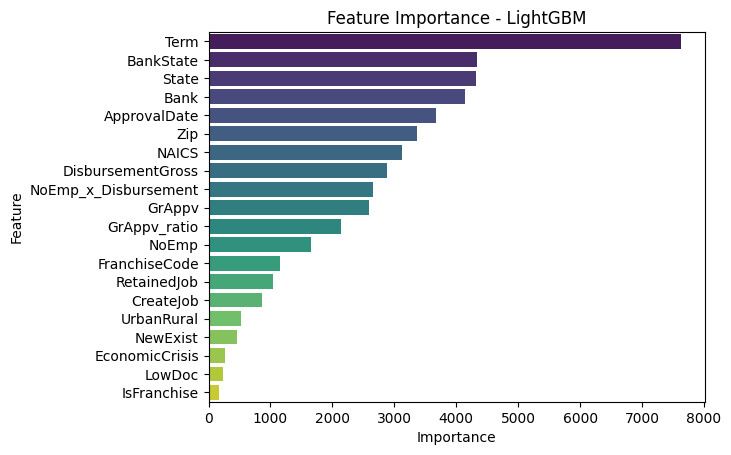

In [28]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()

#### yeeepi!!! Wait during 1 hour for the EconomicCrisis columns, and it's even not really improve the model....